# TASK 7 - Thermoclina-Grafici - :

## Task-7_Thermocline:

Per ogni Dataset ad esclusione di Obs: ['hist', 'pi-Control', 'b990', 'b025', 'b050', 'b065', 'b080', 'b100'] è stata calcola la climatologia della termoclina, principalmente attraverso la definizione (d_T/d_z) ma anche attraverso la versione semplificata dell'isolinea a 20°C. La visualizzazione avviene sia attraverso la rappresentazione della termoclina nel campo di temperatura, che rappresentazione condensata di tutte le termocline in un'unico grafico.
   - Update:
   - la definizione vera di Termoclina è stata implementata: invece che prendere quella a 20° come discriminante viene calcolato la zona di massimo gradiente.
   - Quel che restituisce il calcolo attraverso il grandiente sono dei punti (un punto per ogni punto di griglia), quindiper disegnare la linea sono stati usati più modi: (a)  l'interpolazione (di terzo grado), (b) fit cubico (anche il quadratico si comporta bene), (c) Interpolazione spline con due funzioni diverse di spline, la prima 'splrep + splev' e la seconda che usa 'CubicSpline', con quest'ultima è stata anche rappresentata la derivata 1° della spline.
   - Viene eseguita un'interpolazione spline sulla griglia di definizione del campo sulla cordinata 'lev', cioè sulla profondità per aumentare i livelli e contemporaneamente ricalcolareil campo per avere una termoclina più smooth. Dopo tale interpolazione la teroclina viene calcolata semplicemente attraverso l'interpolazione standard. Si è preferita l'interpolazione spline al regrid del campo perchè questo se lineare non avrebbe cambiato nulla a livello di posizione dei punti della termoclina, in questo modo invece viene ricalcolato tutto il campo.

## Task-8_Composites:

Alla climatologia della termocline del punto precedente sono state calcolate le composites delle due oscillazioni di ENSO, sia quindi per El-Nino che per La-Nina e le differenze con la climatologia in entrambi i 2 tipi di grafici: sia quello con le temperature (contour + contourf) sia qello con le singole linee.

### Nota:

- Il range temporale di riferimento sono i primi e gli ultimi 50 anni di ogni Dataset Bottino, per lo storico è stato usato l'intero range temporale disponibile.
- Il Dataset dell'Osservato non è incluso per mancanza del relativo campo
- Definizione spline: [](https://it.wikipedia.org/wiki/Interpolazione_spline)

In [ ]:
"""
- Leggere letteratura, cercando di rispondere alla domanda: la forma della termoclina, a cosa è legata/cosa implica nella risposta di enso. i.e.  ricerca in letteratura su profondità/forma della termoclina in modelli semplificati, come potrebbe essere connesso al cambio di intensità? (usa perplexity per vedere quali fonti ti suggerisce)
"""

In [1]:
### import libraries ###

# General data analisys libraries 
import numpy as np
import xarray as xr
import pickle
from scipy.interpolate import interp1d, splrep, splev, CubicSpline
#from scipy.interpolate import make_splrep, BSpline --> versioni recenti di scipy (>=1.15.0)
#from scipy.optimize import curve_fit --> per fittare una funzione personalizzata
#from scipy.ndimage import gaussian_filter --> per applicare un filtro gaussino/per rendere una linea un'area
# Plot libraries
#import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# Personal library
import AllePowerFunctions as apf

In [2]:
#Comando che rende le immagini generate visualizzabili
%matplotlib inline

# Test composite nino/nina Pi-control Thetao

controllare serie temporale pi control! verificare che no ci siano buchi nella serie di default del campo.!!!!!!!!!!!!!!!!!!!!!!!!

In [3]:
import cftime
Dataset_pi = xr.open_mfdataset('/nas/archive_CMIP6/CMIP6/model-output/EC-Earth-Consortium/EC-Earth3/piControl/ocean/Omon/r1i1p1f1_r25/thetao/*.nc', decode_times=True, use_cftime=True)

# Riassegnazione dimensione tempo
Dataset_pi['time'] = xr.date_range(start='1850-01-01', end='2349-03-01', periods=None, freq='M', tz=None, normalize=True, name=None, calendar='gregorian', use_cftime=True)

### Recupero dell' Indice Nino 3.4
filename = 'Task-5_Dataset-pi-control.p'
nino_index_pi = pickle.load(open('/home/montanarini/ELNINO/output/Task-5_NinoIndex/Variables/' + filename, 'rb'))[0]


In [4]:
nino_index_pi

<xarray.DataArray 'tos' (time: 6012)>
dask.array<truediv, shape=(6012,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-31 00:00:00 ... 2350-12-31 00:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [ ]:

### Discriminazione del range temporale:     
max_year_dtgr = Dataset_pi['time'].max()
min_year_dtgr = Dataset_pi['time'].min()
# Estremi solo per Hist e Obs
sup_year = str(int(max_year_dtgr.dt.year))+'-01-01'
inf_year = str(int(min_year_dtgr.dt.year))+'-01-01'
# Estremi per i Bottini
sup_year_bott = cftime.DatetimeProlepticGregorian(int(max_year_dtgr.dt.year), 1, 1)
inf_year_bott = cftime.DatetimeProlepticGregorian(int(max_year_dtgr.dt.year-100), 1, 1) # str(int(max_year_dtgr.dt.year)-time_window)+'-01-01'
# sup_year_bott = cftime.DatetimeProlepticGregorian(int(max_year_dtgr.dt.year), 1, 1)
# inf_year_bott = cftime.DatetimeProlepticGregorian(int(max_year_dtgr.dt.year)-time_window, 1, 1)
date_format = '%Y-%m-%d'

### Limitazione del range temporale (non per Hist e Obs)

Dataset_pi = Dataset_pi.sel(time=slice(inf_year_bott, sup_year_bott))
# Seleziono il periodo desiderato dell'indice
nino_index_pi = nino_index_pi.sel(time=slice(inf_year_bott, sup_year_bott)).compute()
# # Conversione indice in DatetimeProlepticGregorian
# if datasetN == 'pi-control':
#     nino_index[datasetN] = nino_index[datasetN].assign_coords(time=[cftime.DatetimeProlepticGregorian(t.year, t.month, t.day) for t in nino_index[datasetN].time.values])

# Indici per la Composite
nino_index_pi_nino = nino_index_pi.where(nino_index_pi.rolling(time=6, min_periods=1, center=True).mean()>=0.4).dropna("time")
nino_index_pi_nina = nino_index_pi.where(nino_index_pi.rolling(time=6, min_periods=1, center=True).mean()<=-0.4).dropna("time")

# Limito il range temporale di Thetao agli ultimi anni togliendo window_thetao
campo = Dataset_pi['thetao'].sel(time=slice(str(int(max_year_dtgr.dt.year) - 50)+'-01-01', sup_year), lat=slice(-5, 5), lon=slice(130, 280)).compute() # 130E - 80W
nino_index_pi_nino = nino_index_pi_nino.sel(time=slice(cftime.DatetimeProlepticGregorian((sup_year_bott.year - 50), 1, 1), sup_year_bott)).compute() # .sel(time=slice(str(int(max_year_dtgr.dt.year)-time_window+window_thetao)+'-01-01', sup_year)).compute()
nino_index_pi_nina = nino_index_pi_nina.sel(time=slice(cftime.DatetimeProlepticGregorian((sup_year_bott.year - 50), 1, 1), sup_year_bott)).compute()

# Detrending del campo
campo_detrended_decycled, anomaly_detrended_decycled, trend_hist, seasonal_cycle = apf.detrending(campo, 360//2)

campo_detrended_decycled = campo_detrended_decycled.mean('time').mean('lat') # Condensiamo al transetto longitudinale

# Intersezione tra le coordinate temporali discontinue dell'Indice
common_times_nino = np.intersect1d(nino_index_pi_nino["time"], anomaly_detrended_decycled["time"])
common_times_nina = np.intersect1d(nino_index_pi_nina["time"], anomaly_detrended_decycled["time"])
# Selezione dal campo solo i punti temporali  condivisi con l'indice e riduzione dimensionale
anomaly_detrended_decycled_nino = anomaly_detrended_decycled.sel(time=common_times_nino).mean('lat').mean('time')
anomaly_detrended_decycled_nina = anomaly_detrended_decycled.sel(time=common_times_nina).mean('lat').mean('time')

# Calcolo delle Composite
composite_nino = anomaly_detrended_decycled_nino#.copy(deep=True)
composite_nina = anomaly_detrended_decycled_nina#.copy(deep=True)

In [ ]:
nino_index_pi

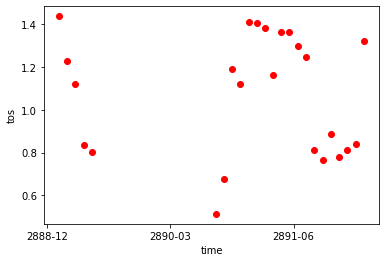

In [4]:
nino_index_nino.isel(time=slice(0,24)).plot(marker='o', linestyle='None', color='red')

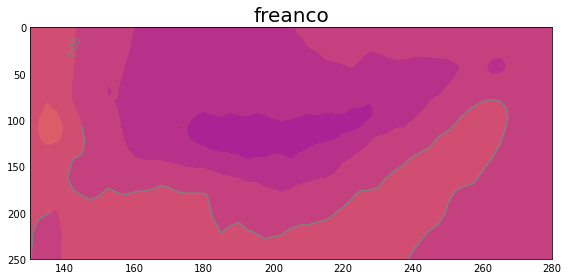

In [17]:
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(8, 4))

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f=np.linspace(-2, 2, 21)
levels_f=np.round(levels_f, 2)
levels=np.arange(-2, 2, 0.5)
levels=np.round(levels, 1)
levels0 = [0] # Level for the termoclina at 20°C
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

# Contour-plot data
scalar=ax.contour(composite_nino['lon'], composite_nino['lev'], composite_nino, levels=levels, colors='gray')
# Add labels to line contours (specify the format)
#fmt_func = lambda x,pos: "{:1.1f}".format(-x) #
#fmt = matplotlib.ticker.FuncFormatter(fmt_func) #
ax.clabel(scalar, inline=True, fontsize=10, fmt='%1.2f')
# Contourf-plot data
scalar_f = ax.contourf(composite_nino['lon'], composite_nino['lev'], composite_nino, cmap='plasma', levels=levels_f, extend='both') # 'plasma', 'inferno', 'magma'
# Set color for NaN
plt.gca().set_facecolor("slategray")
# Set a title for the axes.
ax.set_title('freanco', fontsize=20)
#ax.set_xticklabels(ticks)
ax.set_ylim(250, 0)
# Set y-axis ticks number
ax.set_yticks([0,50,100,150,200,250])

# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

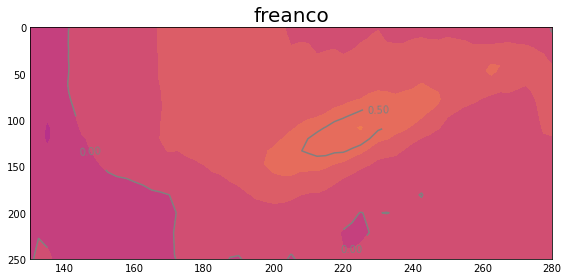

In [18]:
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(8, 4))

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f=np.linspace(-2, 2, 21)
levels_f=np.round(levels_f, 2)
levels=np.arange(-2, 2, 0.5)
levels=np.round(levels, 1)
levels0 = [0] # Level for the termoclina at 20°C
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

# Contour-plot data
scalar=ax.contour(composite_nina['lon'], composite_nina['lev'], composite_nina, levels=levels, colors='gray')
# Add labels to line contours (specify the format)
#fmt_func = lambda x,pos: "{:1.1f}".format(-x) #
#fmt = matplotlib.ticker.FuncFormatter(fmt_func) #
ax.clabel(scalar, inline=True, fontsize=10, fmt='%1.2f')
# Contourf-plot data
scalar_f = ax.contourf(composite_nina['lon'], composite_nina['lev'], composite_nina, cmap='plasma', levels=levels_f, extend='both') # 'plasma', 'inferno', 'magma'
# Set color for NaN
plt.gca().set_facecolor("slategray")
# Set a title for the axes.
ax.set_title('freanco', fontsize=20)
#ax.set_xticklabels(ticks)
ax.set_ylim(250, 0)
# Set y-axis ticks number
ax.set_yticks([0,50,100,150,200,250])

# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

In [ ]:
""" Isolare il singolo mese o la stagione """
#pippo = anomaly_detrended_decycled_nina.groupby('time.month').mean('time').mean('lat')
anomaly_detrended_decycled_nina_month = anomaly_detrended_decycled_nina.sel(time=anomaly_detrended_decycled_nina.time.dt.month.isin([6])).mean('lat')#.plot(marker='o', linestyle='None', color='red')


## Fine Test

In [3]:
""" Regressioni, Termoclina e Composites """

# Directories
common_Dir_home = '/home/montanarini/ELNINO/'
dir_output_6 = 'output/Task-6_Regressions/Variables/'
dir_output_7 = 'output/Task-7_Thermocline/Variables/'
dir_output_8 = 'output/Task-8_Composites/Variables/'
dir_images_7 = 'images/Task-7_Thermocline/'
dir_images_8 = 'images/Task-8_Composites/'

# Lists
dataset_names = ['b990','b025', 'b050', 'b065', 'b080', 'b100', 'pi-control', 'hist', 'obs']
dataset_names_excluded = ['obs']
dataset_names_num = len(dataset_names)
var_names = ['tos', 'thetao', 'tas', 'ua', 'pr', 'zg'] # Variaibili dei datsaset
var_names_sel = ['tos', 'tas', 'ua850', 'ua200', 'pr', 'zg'] # Variaibili che io vado a nominare ed utilizzre: 'thetao' viene aggiunto alla riga 57, dopo la creazione del dizionario
regression_products = ['trend', 'intercept', 'trend_err', 'intercept_err', 'pval'] # Nomi dei prodotti generati dalla funzione che calcola la regressione

# Plots formatting string lists
colors = ['blue', 'green', 'orange', 'red', 'brown', 'purple', 'darkgray', 'olive', 'pink']


# Hist's Dataset Recovering 
Dir_hist_tos = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/r4i1p1f1/Omon_r25/tos/*.nc' # Modello storico #'/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/r4i1p1f1/Omon/tos_rg_1850-2014.nc'
Dataset_hist_tos = xr.open_mfdataset(Dir_hist_tos)
Dataset_hist_tos = Dataset_hist_tos.sel(lat=slice(-85, 85)).compute() # lat=slice(-5, 5), lon=slice(190, 240)
hist_tos = Dataset_hist_tos['tos']
# tas --> T2m
# Dir_hist_tas = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/r4i1p1f1/Amon/tas/*.nc'
# Dataset_hist_tas = xr.open_mfdataset(Dir_hist_tas)
# Dataset_hist_tas = Dataset_hist_tas.sel(lat=slice(-5, 5), lon=slice(190, 240)).compute()
# hist_tas = Dataset_hist_tos['tas']


### Coordinates aquisition

# Getting the Coordinates
latO = hist_tos['lat'] # Ocean's Latitude 
lonO = hist_tos['lon'] # Ocean's Longitude
lon_o = lonO.copy() # For not overwrite the lonO var in the hiding of the the white longitude line

# latA = hist_tas['lat'] # Atmosphere's Latitude 
# lonA = hist_tas['lon'] # Atmosphere's Longitude 

# Maschera continentale
continental_mask = np.isnan(hist_tos)[0,...]


# Regression variables Dictionary  declaration
variables_dict = {}  # Dizionario per raccogliere i risultati delle elaborazioni dei dataset
for product in regression_products:
    variables_dict[product] = {}
    for var in var_names_sel:
        variables_dict[product][var] = {}
        for datasetN in dataset_names:
            variables_dict[product][var][datasetN] =  [[[[None]*len(lonO) for _ in range(len(latO))] for _ in dataset_names] for _ in var_names_sel]
termo = [None for _ in range(dataset_names_num-1)]
var_names_sel.insert(1, 'thetao') # lista su cui vado ad eseguire il main loop
print(var_names_sel)

# Composite dictionary declaration
composite_dict = {}
oscilaltion = ['nino', 'nina']
for phase in oscilaltion:
    composite_dict[phase] = {}
    for var in var_names_sel:
        composite_dict[phase][var] = {}
        if var == 'thetao':
            for datasetN in dataset_names:
                # print(var, datasetN)
                composite_dict[phase][var][datasetN] =  [[None]*len(lonO) for _ in range(63)] # 63 sonno i livelli di profondità del termoclino 
                # (questa cosa può anche non essere specificata, lo faccio per fare il figo perchè così il compilatore sa già quanto spazio riservare alla variaibile da allocare)
                # print(np.shape(composite_dict[phase][var][datasetN]))
        else: # var != 'thetao': #var not in ['thetao']:
            for datasetN in dataset_names:
                # print(var, datasetN)
                composite_dict[phase][var][datasetN] =  [[None]*len(lonO) for _ in range(len(latO))]
                # print(np.shape(composite_dict[phase][var][datasetN]))



#################################################################################################################################################
########################################################## Caricamento Variabili ################################################################
#################################################################################################################################################
print('Main loop, start loading the variables')

for i, var in enumerate(var_names_sel):
    
    for j, datasetN in enumerate(dataset_names):

        if var not in ['thetao']:
            
            if (var != 'tos' and datasetN == 'obs'): # skip each iteration for Dataset 'obs' except for 'tos'
                continue
            else:
                filename_reg = f'Task-6_{var}-Products-{datasetN}.pkl'
                data_recov_reg = pickle.load(open(common_Dir_home + dir_output_6 + filename_reg, 'rb'))
                filename_comp = f'Task-8_{var}-Composite-{datasetN}.pkl'
                data_recov_comp = pickle.load(open(common_Dir_home + dir_output_8 + filename_comp, 'rb'))

                for k, product in enumerate(regression_products):
                    variables_dict[product][var][datasetN] = data_recov_reg[k] # k deve andare da 0 a 4, cioè gli elementi in 'product'
                    if (datasetN == 'obs' and product == 'trend'):
                        variables_dict[product][var][datasetN] = xr.DataArray(variables_dict[product][var][datasetN], dims=['lat', 'lon'], coords={'lat':latO, 'lon':lonO})
                        variables_dict[product][var][datasetN] = xr.where(((np.abs(variables_dict[product][var][datasetN]) >  0.6) & 
                                                                            (variables_dict[product][var][datasetN]['lat'] > 50)) | 
                                                                            ((np.abs(variables_dict[product][var][datasetN]) >  0.3) & 
                                                                                (variables_dict[product][var][datasetN]['lat'] < -55)), 
                                                                                np.nan, variables_dict[product][var][datasetN])
                for phase in oscilaltion:
                    if phase == 'nino':
                        composite_dict[phase][var][datasetN] = data_recov_comp[0]
                    elif phase == 'nina':
                        composite_dict[phase][var][datasetN] = data_recov_comp[1]
                    
                    if datasetN == 'obs':
                        composite_dict[phase][var][datasetN] = xr.DataArray(composite_dict[phase][var][datasetN], dims=['lat', 'lon'], coords={'lat':latO, 'lon':lonO})
                        composite_dict[phase][var][datasetN] = xr.where(((np.abs(composite_dict[phase][var][datasetN]) >  0.6) & 
                                                                        (composite_dict[phase][var][datasetN]['lat'] > 50)) | 
                                                                        ((np.abs(composite_dict[phase][var][datasetN]) >  0.3) & 
                                                                            (composite_dict[phase][var][datasetN]['lat'] < -55)), 
                                                                            np.nan, composite_dict[phase][var][datasetN])

        else: #var == 'thetao':
            
            if datasetN != 'obs':
                filename = 'Task-7-{}.pkl'.format(datasetN)
                data_recov_thetao = pickle.load(open(common_Dir_home+dir_output_7+filename, 'rb'))
                # print(data_recov_thetao[1].shape, '\n',data_recov_thetao[0].shape)
                termo[j] = data_recov_thetao[0]
                composite_dict['nino'][var][datasetN] = data_recov_thetao[1]
                composite_dict['nina'][var][datasetN] = data_recov_thetao[2]
        

    
        print(f'Dati del dataset {datasetN} caricati con successo')
    print(f'\nDati del campo {var} caricati con successo\n')

# regression_product_dict['trend']['tos'][i]
#     0 = trend
#     1 = intercept
#     2 = trend_err
#     3 = intercept_err
#     4 = pval
#     5 = thetao
#
# variables_dict[(dataset)][i]
# number: 
#     0 = trend
#     1 = intercept
#     2 = trend_err
#     3 = intercept_err
#     4 = pval
#     5 = thetao

  
###########################################################################################################################################
#Box nel pacifico per Ninõ
lat_south, lat_north = -5, 5
lon_east, lon_west = 190, 240
# Create a figure with Equidist-Cylindrical proj.
proj0 = ccrs.PlateCarree()
proj=ccrs.PlateCarree(central_longitude=205)

['tos', 'thetao', 'tas', 'ua850', 'ua200', 'pr', 'zg']
Main loop, start loading the variables
Dati del dataset b990 caricati con successo
Dati del dataset b025 caricati con successo
Dati del dataset b050 caricati con successo
Dati del dataset b065 caricati con successo
Dati del dataset b080 caricati con successo
Dati del dataset b100 caricati con successo
Dati del dataset pi-control caricati con successo
Dati del dataset hist caricati con successo
Dati del dataset obs caricati con successo

Dati del campo tos caricati con successo

Dati del dataset b990 caricati con successo
Dati del dataset b025 caricati con successo
Dati del dataset b050 caricati con successo
Dati del dataset b065 caricati con successo
Dati del dataset b080 caricati con successo
Dati del dataset b100 caricati con successo
Dati del dataset pi-control caricati con successo
Dati del dataset hist caricati con successo
Dati del dataset obs caricati con successo

Dati del campo thetao caricati con successo

Dati del datase

In [3]:
""" Thermoclina e Composites """


# Directories
common_Dir_home = '/home/montanarini/ELNINO/'
dir_output_7 = 'output/Task-7_Thermocline/Variables/'
dir_images_7 = 'images/Task-7_Thermocline/'
dir_images_8 = 'images/Task-8_Composites/'

# Lists
dataset_names = ['hist', 'pi-control', 'b990','b025', 'b050', 'b065', 'b080', 'b100'] #['b990','b025', 'b050', 'b065', 'b080', 'b100', 'pi-control', 'hist']
dataset_names_num = len(dataset_names)
var_names = ['thetao']

# Plots formatting string lists
colors = ['olive', 'darkgray', 'blue', 'green', 'orange', 'red', 'brown', 'purple'] #['blue', 'green', 'orange', 'red', 'brown', 'purple', 'darkgray', 'olive']


# Hist's Dataset Recovering 
Dir_hist_tos = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/r4i1p1f1/Omon_r25/tos/*.nc' # Modello storico #'/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/r4i1p1f1/Omon/tos_rg_1850-2014.nc'
Dataset_hist_tos = xr.open_mfdataset(Dir_hist_tos)
Dataset_hist_tos = Dataset_hist_tos.sel(lat=slice(-5, 5), lon=slice(130, 280)).compute() # stesso slice del campo delle termocline
hist_tos = Dataset_hist_tos['tos']
# tas --> T2m
# Dir_hist_tas = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/r4i1p1f1/Amon/tas/*.nc'
# Dataset_hist_tas = xr.open_mfdataset(Dir_hist_tas)
# Dataset_hist_tas = Dataset_hist_tas.sel(lat=slice(-5, 5), lon=slice(190, 240)).compute()
# hist_tas = Dataset_hist_tos['tas']


### Coordinates aquisition ###

# Getting the Coordinates
latO = hist_tos['lat'] # Ocean's Latitude 
lonO = hist_tos['lon'] # Ocean's Longitude
lon_o = lonO.copy() # For not overwrite the lonO var in the hiding of the the white longitude line

# latA = hist_tas['lat'] # Atmosphere's Latitude 
# lonA = hist_tas['lon'] # Atmosphere's Longitude 

# Maschera continentale
continental_mask = np.isnan(hist_tos)[0,...]

termo = [None for _ in range(dataset_names_num)]
# Composite dictionary declaration
composite = {}
oscillation = ['nino', 'nina']
for phase in oscillation:
    composite[phase] = {}
    for var in var_names:
        composite[phase][var] = {}
        for datasetN in dataset_names:
            composite[phase][var][datasetN] = [None]
# composite_dict = {}
# oscilaltion = ['nino', 'nina']
# for phase in oscilaltion:
#     composite_dict[phase] = {}
#     for datasetN in dataset_names:
#         composite_dict[phase][datasetN] =  [[None]*50 for _ in range(63)] # 'len(lonO)' ; 63 sonno i livelli di profondità del termoclino 
#                                                                                         # (questa cosa può anche non essere specificata,
#                                                                                         # lo faccio per fare il figo perchè così il compilatore
#                                                                                         # sa già quanto spazio riservare alla variaibile da allocare)


#################################################################################################################################################
########################################################## Caricamento Variabili ################################################################
#################################################################################################################################################
print('Main loop, start loading the variables for Thermocline field')

for j, datasetN in enumerate(dataset_names):
    filename = 'Task-7-{}.pkl'.format(datasetN)
    # with open(common_Dir_home + dir_output_7 + filename, 'rb') as f:
    #     data_recov_thetao = pickle.load(f)#data_recov_thetao = pickle.load(open(common_Dir_home + dir_output_7 + filename, 'rb'))
    data_recov_thetao = pickle.load(open(common_Dir_home + dir_output_7 + filename, 'rb'))
    # print("Loaded types:", [type(x) for x in data_recov_thetao])
    # print("Loaded ids (values):", [id(getattr(x,"values",x)) for x in data_recov_thetao])
    termo[j] = data_recov_thetao[0]
    composite['nino']['thetao'][datasetN] = data_recov_thetao[1]
    composite['nina']['thetao'][datasetN] = data_recov_thetao[2]
    print(f'Dati del dataset {datasetN} caricati con successo')
  
###########################################################################################################################################
# Box nel pacifico per Nino
lat_south, lat_north = -5, 5
lon_east, lon_west = 190, 240
# Create a figure with Equidist-Cylindrical proj.
proj0 = ccrs.PlateCarree()
proj=ccrs.PlateCarree(central_longitude=205)

Main loop, start loading the variables for Thermocline field
Dati del dataset hist caricati con successo
Dati del dataset pi-control caricati con successo
Dati del dataset b990 caricati con successo
Dati del dataset b025 caricati con successo
Dati del dataset b050 caricati con successo
Dati del dataset b065 caricati con successo
Dati del dataset b080 caricati con successo
Dati del dataset b100 caricati con successo


In [ ]:
#### Calcolare il livello di profondità
def find_t_depth(da, temp):
    depth = da.lev[(da > temp).sum(axis = 0)+1]
    return depth

In [4]:
### Interpolazione dei livelli profondità del campo
# (Nota: alcune operazioni sono state ripetute aggiungendo al campo della climatologia le anomalie durante gli episodi Nino e Nina)

# Coordinate (supponendo siano uguali per tutti)
lev = termo[0]['lev']
lon = termo[0]['lon']
# Interpolazione longitudine
lon_ext = np.linspace(lon.min(), lon.max(), 500)

termo_interp = [None for _ in range(dataset_names_num)]
termo_nino_interp = [None for _ in range(dataset_names_num)]
termo_nina_interp = [None for _ in range(dataset_names_num)]
for i, datasetN in enumerate(dataset_names):
   termo_lim = termo[i].sel(lev=slice(0,300)) # limitazione interpolazione solamente al Mixed Layer
   # Interpolazione livelli   
   lev_ext = xr.DataArray(np.linspace(termo_lim['lev'].min().values, termo_lim['lev'].max().values, 500), dims=['lev_ext'])
   # Applico la spine alla coordinata di profondità (z) -'lev'- per ogni punto di longitudine e ricalcolo il valore del campo nei nuoi punti
   termo_interp[i] = apf.spline_interpolation(
      termo[i],
      lev_ext,
      "lev",
      4,
      "natural"
   )
   termo_nino_interp[i] = apf.spline_interpolation(
      termo[i]+composite['nino']['thetao'][datasetN],
      lev_ext,
      "lev",
      4,
      "natural"
   )
   termo_nina_interp[i] = apf.spline_interpolation(
      termo[i]+composite['nina']['thetao'][datasetN],
      lev_ext,
      "lev",
      4,
      "natural"
   )

### Calcolo del gradiente della temperatura

# Lists declaration
dT_dlev = [None for _ in range(dataset_names_num)] # Gradiente della temperatura rispetto alla profondità
dT_dlev_nino = [None for _ in range(dataset_names_num)]
dT_dlev_nina = [None for _ in range(dataset_names_num)]
termoclina = [None for _ in range(dataset_names_num)] # Termoclina vera e propria, non plottabile
lev_max_grad = [None for _ in range(dataset_names_num)] # I livelli di profondità corrispondnenti alla termoclina
lev_max_grad_nino = [None for _ in range(dataset_names_num)]
lev_max_grad_nina = [None for _ in range(dataset_names_num)]
# Per metodo 1, interpolazione
termoclina_interp = [None for _ in range(dataset_names_num)] # Interpolazione dei punti della termoclina
lev_interp = [None for _ in range(dataset_names_num)] # Interpolazione della longitudine
# Per metodo 2, interpolazione spline
spline, spline_interp = [None for _ in range(dataset_names_num)], [None for _ in range(dataset_names_num)] # Calcolo della spline e la sua valutazione
cubic_spline = [None for _ in range(dataset_names_num)]
cubic_spline_nino = [None for _ in range(dataset_names_num)]
cubic_spline_nina = [None for _ in range(dataset_names_num)]
# Per metodo 3, fit polinomiale
pol = [None for _ in range(dataset_names_num)]

for i, datasetN in enumerate(dataset_names):
   # Calcolo del gradiente
   dT_dlev[i] = termo_interp[i].differentiate('lev')
   dT_dlev_nino[i] = termo_nino_interp[i].differentiate('lev')
   dT_dlev_nina[i] = termo_nina_interp[i].differentiate('lev')
   # Calcolo dell'indice del massimo gradiente in modulo per ogni lon (<--> Trova per ogni colonna il livello più vicino alla temperatura target)
   abs_dT_dlev = np.abs(dT_dlev[i])
   abs_dT_dlev_nino = np.abs(dT_dlev_nino[i])
   abs_dT_dlev_nina = np.abs(dT_dlev_nina[i])
   idx_max_grad = abs_dT_dlev.argmax(dim='lev') #(temp - target_temp).argmin(axis=0) se non si avesse il massimo del gradiente ma una temperatura target
   idx_max_grad_nino = abs_dT_dlev_nino.argmax(dim='lev')
   idx_max_grad_nina = abs_dT_dlev_nina.argmax(dim='lev')
   # Coordinate del livello di massimo gradiente
   lev_max_grad[i] = termo_interp[i]['lev'].isel(lev=idx_max_grad) #(<-->lev[idx_max_grad])
   lev_max_grad_nino[i] = termo_nino_interp[i]['lev'].isel(lev=idx_max_grad_nino)
   lev_max_grad_nina[i] = termo_nina_interp[i]['lev'].isel(lev=idx_max_grad_nina)
        # Se quel che dovesimo trovare fosse il livello/coordinate più vicine ad un dato valore:
        # Trova per ogni colonna il livello più vicino alla temperatura target
        # target_temp = 20 # Temperatura target per la termoclina
        # idx_thermocline = np.abs(temp - target_temp).argmin(axis=0)
        # lev_thermocline = lev[idx_thermocline]
   termoclina[i] = termo_interp[i].sel(lev=lev_max_grad[i], method='nearest').values # --> questa è la termoclina vera e prorpia, ma non è plottabile facilmetne così com'è
   
   ### Tre metodi per rappresentare la termoclina: Interpolazione (metodo Cubico), Interpolazione Spline, Fit Polinomiale
 
   ## Metodo 1: Eseguire l'interpolazione per unire i punti di massimo gradiente (1pt/lon)
   # Interpolazione
   termoclina_interp[i] = interp1d(termo_interp[i]['lon'], lev_max_grad[i], kind='cubic')  # tipo: 'linear', 'quadratic', 'cubic'
   lev_interp[i] = termoclina_interp[i](lon_ext)

   ## Metodo 2: Eseguire l'interpolazione Spline.
   #Sia spline_interp che cubic_spline sono delle spline cubiche ma usano due funzioni diverse, una procedurale l'altra orientata ad oggetti
   spline[i] = splrep(lon, lev_max_grad[i], k=3, s=0)
   spline_interp[i] = splev(lon_ext, spline[i]) 
   cubic_spline[i] = CubicSpline(lon, lev_max_grad[i], bc_type='natural') # not-a-knot (default), natural, clamped
   cubic_spline_nino[i] = CubicSpline(lon, lev_max_grad_nino[i], bc_type='natural')
   cubic_spline_nina[i] = CubicSpline(lon, lev_max_grad_nina[i], bc_type='natural')

   ## Metodo 3: Eseguire un fit sui punti della termoclina
   ### Fit polinomiale
   coeff_pol = np.polyfit(lev_max_grad[i]['lon'], lev_max_grad[i].values, 3) # rcond=None, full=False, w=None, cov=False
   pol[i] = np.polyval(coeff_pol, lon_ext)

   ## Metodo 4: eseguire un .contour() solo con i valori della termoclina attraverso un'array maschera
      # --> questo metodo non funziona, il .contour() non può disegnare contorni dove c'è un singolo valore per colonna/riga e tutti gli altri NaN


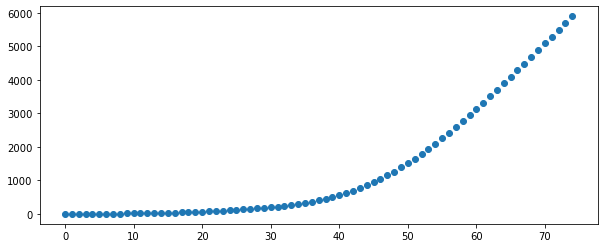

In [ ]:
# Livelli profondità
fig, ax = plt.subplots(figsize=(10, 4))
# Scatters plot
ax.scatter(np.arange(0,len(termo[0]['lev'])), termo[0]['lev'])

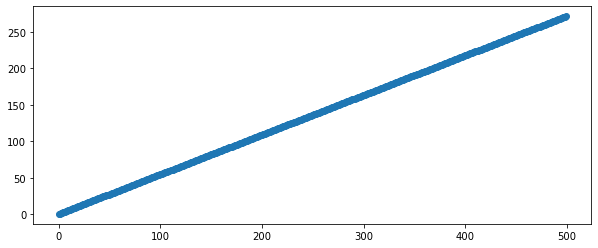

In [9]:
# Livelli profondità
fig, ax = plt.subplots(figsize=(10, 4))
# Scatters plot
ax.scatter(np.arange(0,len(termo_interp[5]['lev'])), termo_interp[5]['lev'])

In [6]:
# Estremi transetto temperatura
for i, datasetN in enumerate(dataset_names):
   min, max = np.min(termo[i]), np.max(termo[i])
   print(f'Min e Max {datasetN}',min.values, max.values)

Min e Max b990 2.0434296131134033 30.3585262298584
Min e Max b025 2.1188089847564697 31.508459091186523
Min e Max b050 2.1426215171813965 32.382442474365234
Min e Max b065 2.137404680252075 33.50276565551758
Min e Max b080 2.127497911453247 34.386043548583984
Min e Max b100 2.11375093460083 35.38804244995117
Min e Max pi-control 1.4006949663162231 29.33884048461914
Min e Max hist 1.3153733015060425 30.323482513427734


/tmp/ipykernel_183928/4042331271.py:41: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
/tmp/ipykernel_183928/4042331271.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


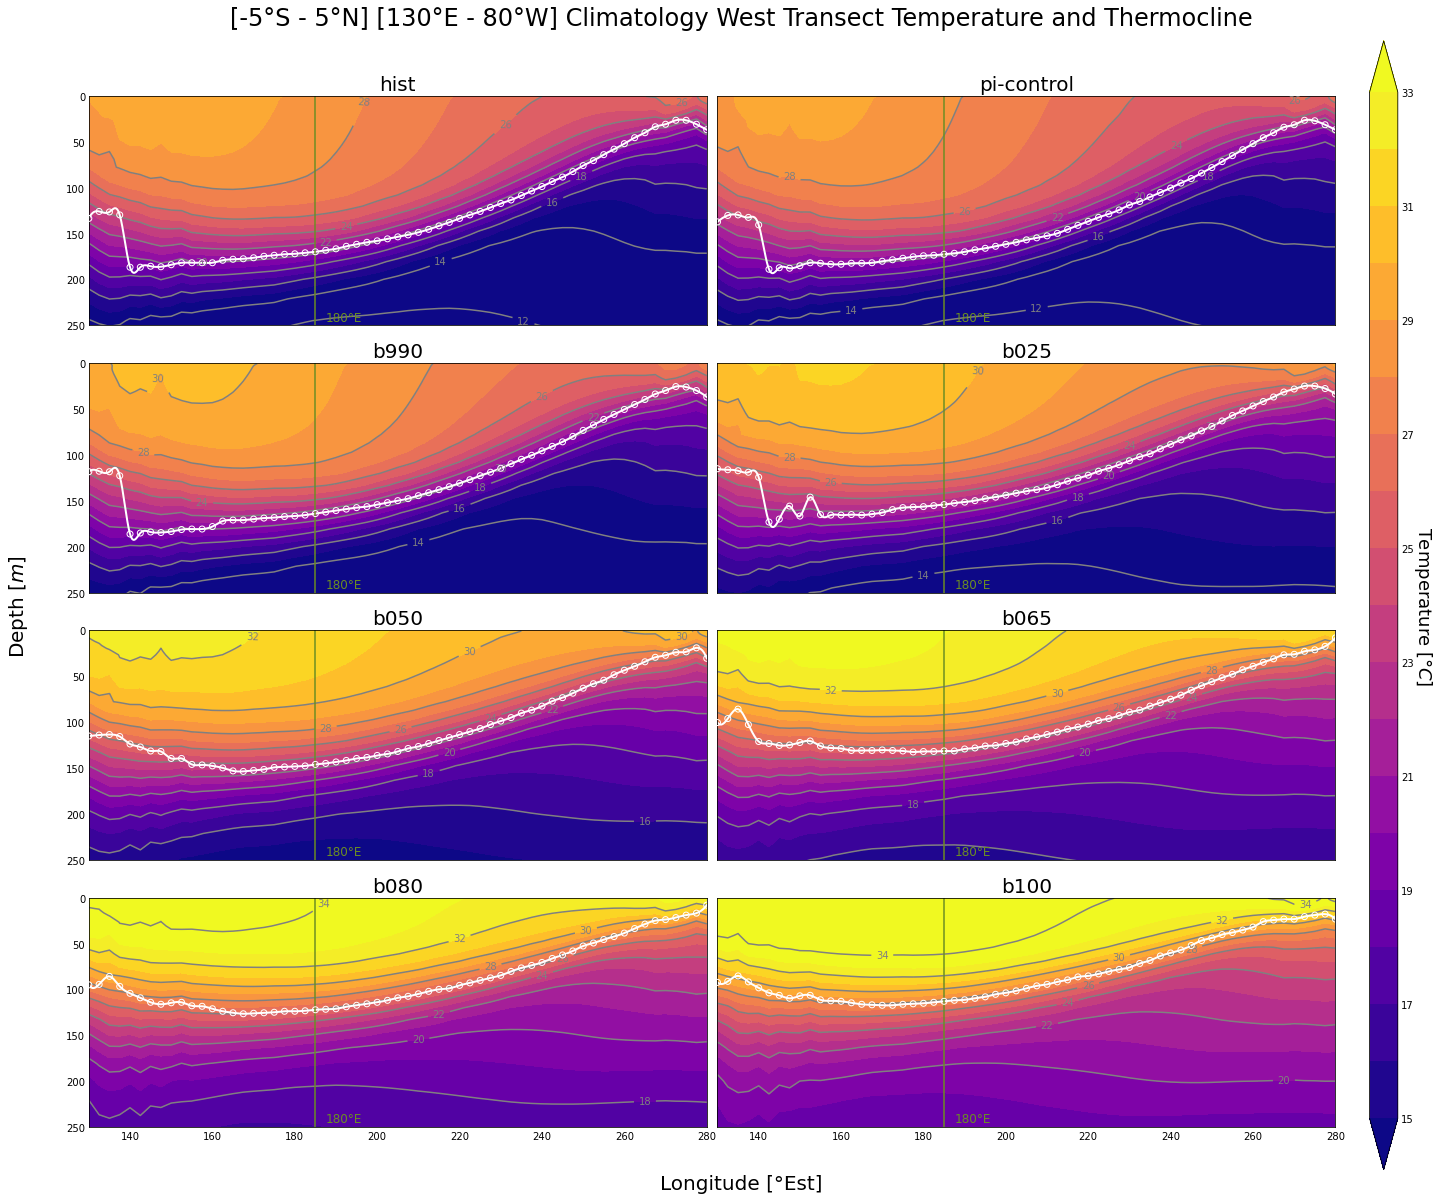

In [5]:
################################################################################################
#################### Termoclina Trasect Plot [-5°S - 5°N] [130°E - 80°W] #######################
################################## Interpolazione Cubica #######################################
###################################### last 50 years ###########################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 16)) #(16, 8)

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f = np.arange(15, 34, 1).round(2)
levels = np.arange(12, 36, 2).round(2)
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

for i, datasetN in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   # Contour-plot data
   scalar = axs[row, col].contour(termo[i]['lon'], termo[i]['lev'], termo[i], levels=levels, colors='gray')
   thermocline = axs[row, col].plot(lon_ext, lev_interp[i], color='white', linewidth=2, label='Thermocline')
   thermocline_scatter = axs[row, col].scatter(lon, lev_max_grad[i], marker='o', facecolors='none', edgecolors='white', zorder=10)
   # Add labels to line contours (specify the format)
   # fmt_func = lambda x,pos: "{:1.1f}".format(-x)
   # fmt = matplotlib.ticker.FuncFormatter(fmt_func)
   axs[row, col].clabel(scalar, inline=True, fontsize=10, fmt='%1.0f')
   # Contourf-plot data
   scalar_f = axs[row, col].contourf(termo[i]['lon'], termo[i]['lev'], termo[i], cmap='plasma', levels=levels_f, extend='both')
   # Set color for NaN
   plt.gca().set_facecolor("slategray")
   # Set a title for the axes.
   axs[row, col].set_title('{}'.format(datasetN), fontsize=20)
   #axs[row, col].set_xticklabels(ticks)
   axs[row, col].set_ylim(250, 0)
   # Set y-axis ticks number
   axs[row, col].set_yticks([0,50,100,150,200,250])
   if col == 1:
      axs[row, col].set_yticklabels("")
   if row != 3:
      axs[row, col].set_xticklabels("")

# Add color bar
cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
cbar.ax.set_ylabel('Temperature ' r'$[°C]$', fontsize=18, rotation=270, labelpad=20)

# Set axes options.
for ax in axs.flat:
   ax.axvline(termo[0]['lon'][22], color='olivedrab', linestyle='-')
   ax.text(termo[0]['lon'][23], termo[0]['lev'][32], '180°E', color='olivedrab', fontsize=12)
# Set Sup-stuff
fig.suptitle('[-5°S - 5°N] [130°E - 80°W] Climatology West Transect Temperature and Thermocline',  y=1.02, fontsize=24) #  y=1.02 for setting the distance of the suptitle from the figure
fig.supylabel('Depth 'r'$[m]$', fontsize=20, x=-0.01)
fig.supxlabel('Longitude [°Est]', fontsize=20, y=-0.01)
# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_7 + 'Clim_ThermoclinesInterpCubic.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_7 + 'Clim_ThermoclinesInterpCubic.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

/tmp/ipykernel_145081/2653331574.py:41: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
/tmp/ipykernel_145081/2653331574.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


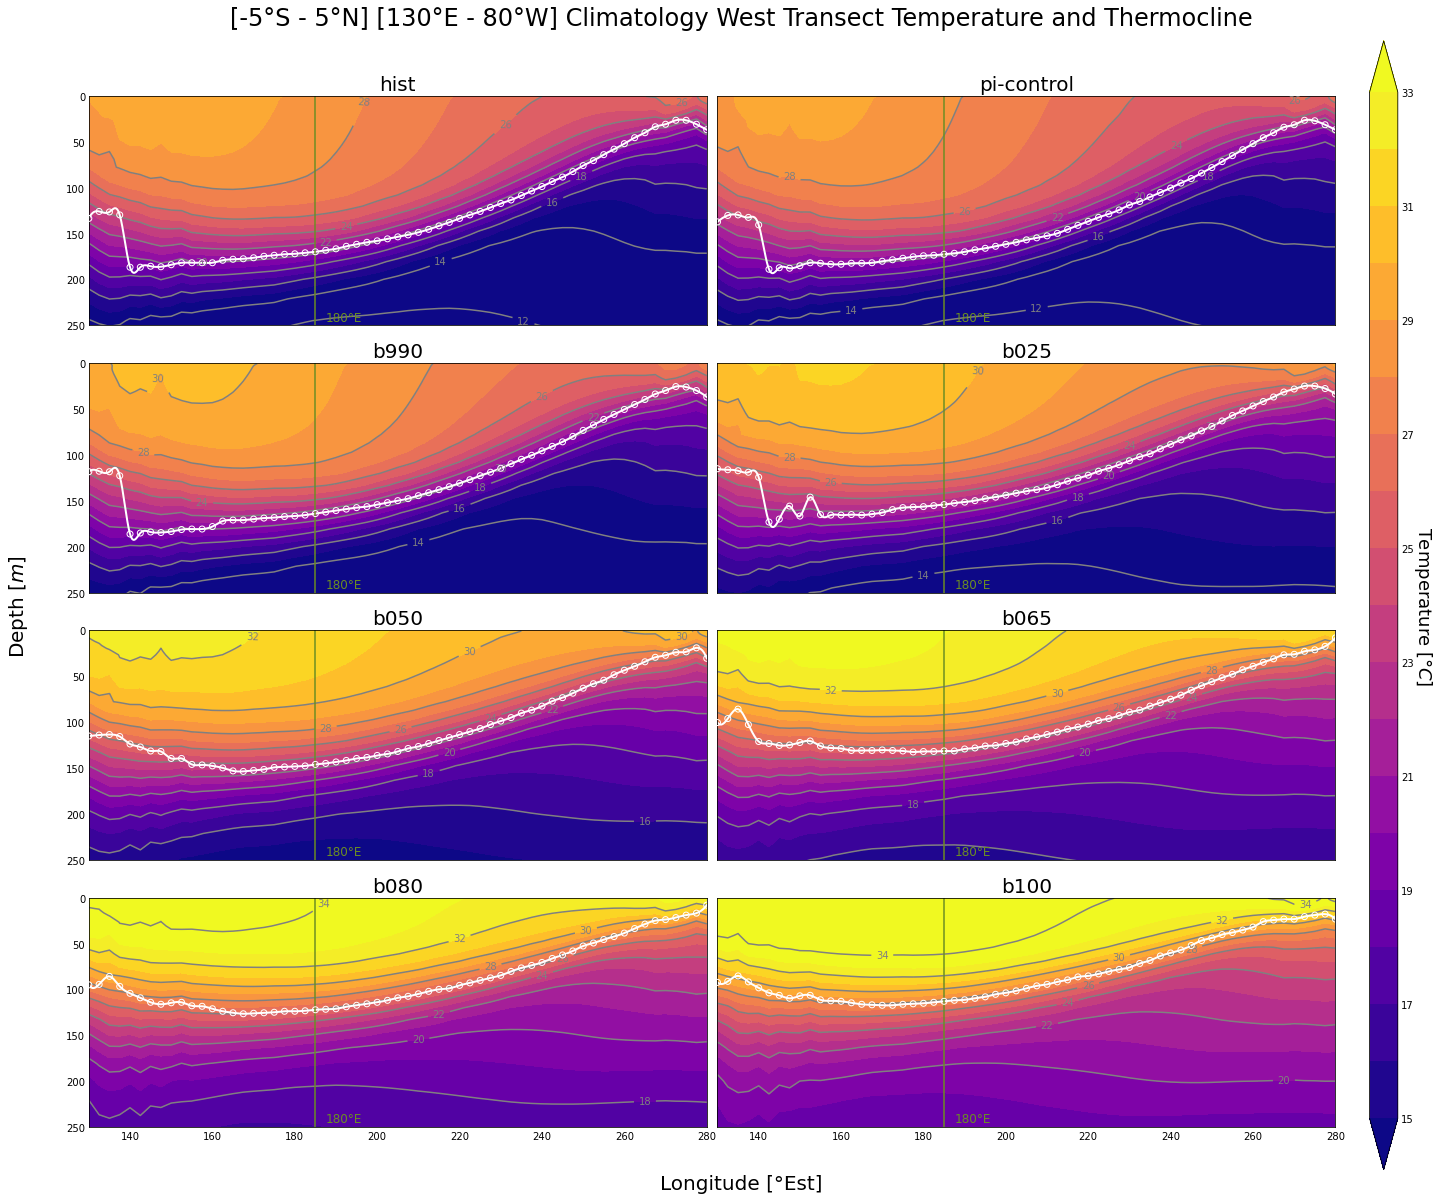

In [5]:
################################################################################################
#################### Termoclina Trasect Plot [-5°S - 5°N] [130°E - 80°W] #######################
################################ Interpolazione-Spline k=3 #####################################
###################################### last 50 years ###########################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 16)) #(16, 8)

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f = np.arange(15, 34, 1).round(2)
levels = np.arange(12, 36, 2).round(2)
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

for i, datasetN in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   # Contour-plot data
   scalar = axs[row, col].contour(termo[i]['lon'], termo[i]['lev'], termo[i], levels=levels, colors='gray')
   thermocline = axs[row, col].plot(lon_ext, spline_interp[i], color='white', linewidth=2, label='Thermocline')
   thermocline_scatter = axs[row, col].scatter(lon, lev_max_grad[i], marker='o', facecolors='none', edgecolors='white', zorder=10)
   # Add labels to line contours (specify the format)
   # fmt_func = lambda x,pos: "{:1.1f}".format(-x)
   # fmt = matplotlib.ticker.FuncFormatter(fmt_func)
   axs[row, col].clabel(scalar, inline=True, fontsize=10, fmt='%1.0f')
   # Contourf-plot data
   scalar_f = axs[row, col].contourf(termo[i]['lon'], termo[i]['lev'], termo[i], cmap='plasma', levels=levels_f, extend='both')
   # Set color for NaN
   plt.gca().set_facecolor("slategray")
   # Set a title for the axes.
   axs[row, col].set_title('{}'.format(datasetN), fontsize=20)
   #axs[row, col].set_xticklabels(ticks)
   axs[row, col].set_ylim(250, 0)
   # Set y-axis ticks number
   axs[row, col].set_yticks([0,50,100,150,200,250])
   if col == 1:
      axs[row, col].set_yticklabels("")
   if row != 3:
      axs[row, col].set_xticklabels("")

# Add color bar
cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
cbar.ax.set_ylabel('Temperature ' r'$[°C]$', fontsize=18, rotation=270, labelpad=20)

# Set axes options.
for ax in axs.flat:
   ax.axvline(termo[0]['lon'][22], color='olivedrab', linestyle='-')
   ax.text(termo[0]['lon'][23], termo[0]['lev'][32], '180°E', color='olivedrab', fontsize=12)
# Set Sup-stuff
fig.suptitle('[-5°S - 5°N] [130°E - 80°W] Climatology West Transect Temperature and Thermocline',  y=1.02, fontsize=24) #  y=1.02 for setting the distance of the suptitle from the figure
fig.supylabel('Depth 'r'$[m]$', fontsize=20, x=-0.01)
fig.supxlabel('Longitude [°Est]', fontsize=20, y=-0.01)
# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_7 + 'Clim_ThermoclinesInterpSpline.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_7 + 'Clim_ThermoclinesInterpSpline.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

/tmp/ipykernel_145081/1569659998.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
/tmp/ipykernel_145081/1569659998.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


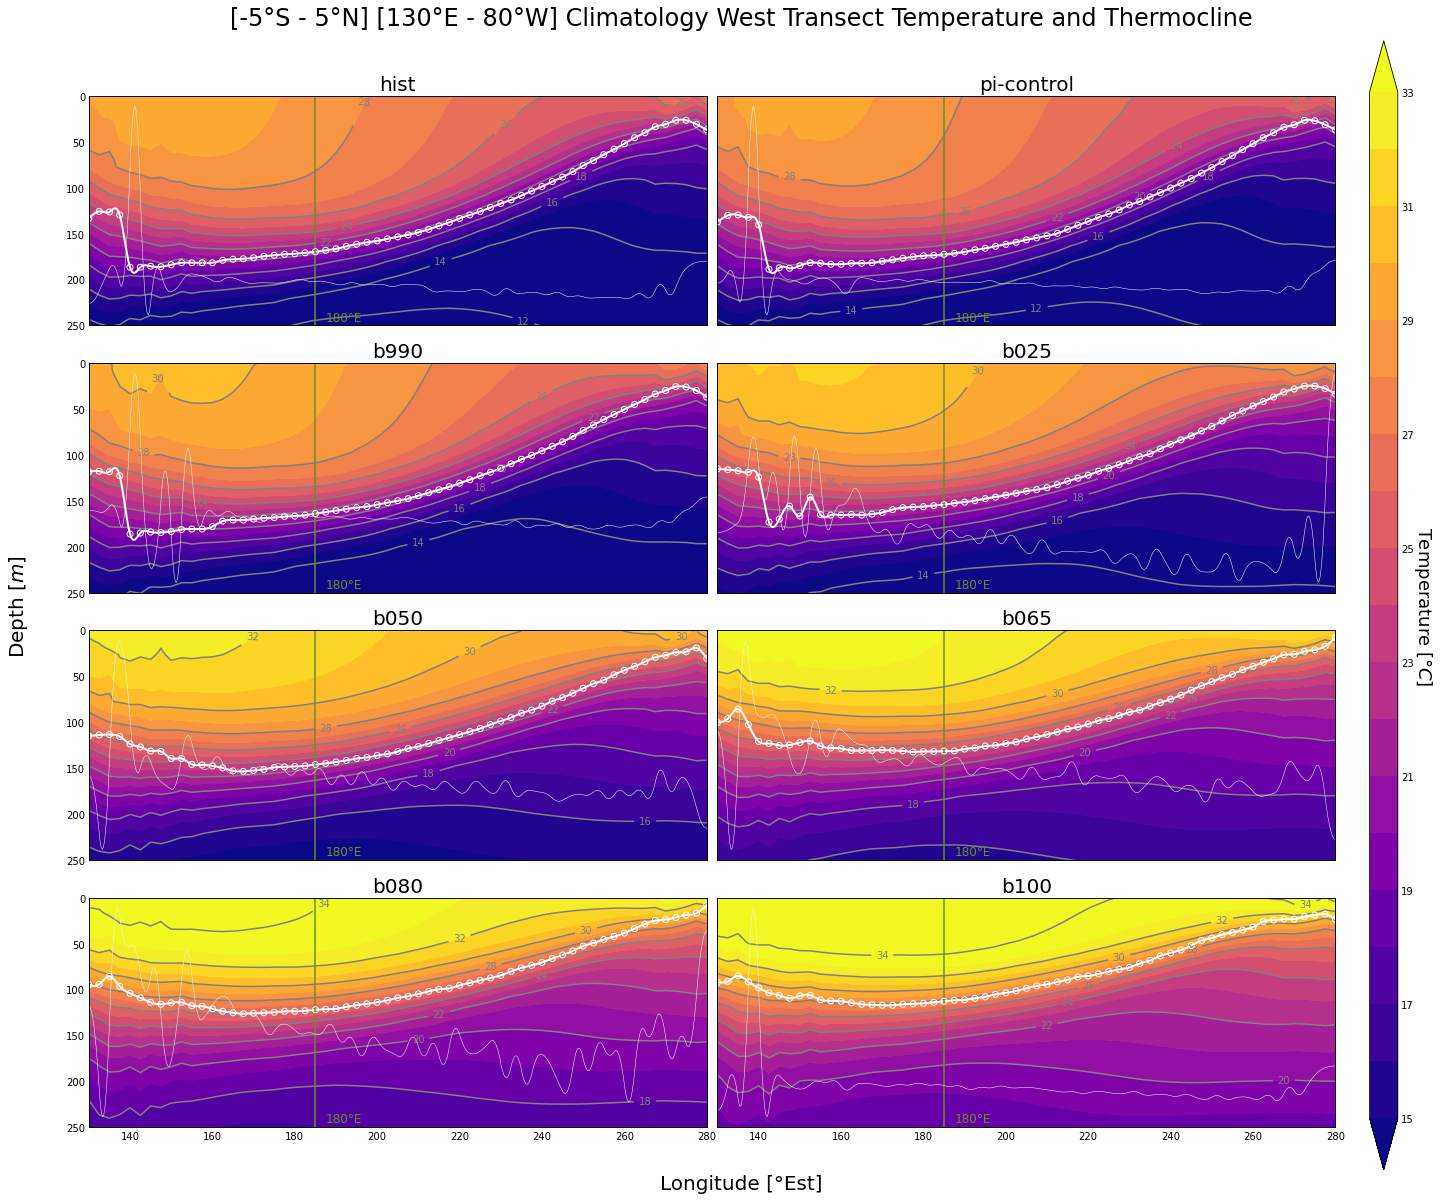

In [6]:
################################################################################################
#################### Termoclina Trasect Plot [-5°S - 5°N] [130°E - 80°W] #######################
########################### Interpolazione-Spline CubicSpline ##################################
###################################### last 50 years ###########################################
################################################################################################
""" natural """
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 16)) #(16, 8)

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f = np.arange(15, 34, 1).round(2)
levels = np.arange(12, 36, 2).round(2)
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

for i, datasetN in enumerate(dataset_names):
   # Add a supplementary y-axes
   twin = axs[row, col].twinx()
   row = i // 2
   col = i % 2
   # Contour-plot data
   scalar = axs[row, col].contour(termo[i]['lon'], termo[i]['lev'], termo[i], levels=levels, colors='gray')
   thermocline = axs[row, col].plot(lon_ext, cubic_spline[i](lon_ext), color='white', linewidth=2, label='Thermocline')
   thermocline_der = twin.plot(lon_ext, cubic_spline[i](lon_ext, 1), color='whitesmoke', linewidth=0.5, label='Thermocline Derivate')
   thermocline_scatter = axs[row, col].scatter(lon, lev_max_grad[i], marker='o', facecolors='none', edgecolors='white', zorder=10)
   # Add labels to line contours (specify the format)
   # fmt_func = lambda x,pos: "{:1.1f}".format(-x)
   # fmt = matplotlib.ticker.FuncFormatter(fmt_func)
   axs[row, col].clabel(scalar, inline=True, fontsize=10, fmt='%1.0f')
   # Contourf-plot data
   scalar_f = axs[row, col].contourf(termo[i]['lon'], termo[i]['lev'], termo[i], cmap='plasma', levels=levels_f, extend='both')
   # Set color for NaN
   plt.gca().set_facecolor("slategray")
   # Set a title for the axes.
   axs[row, col].set_title('{}'.format(datasetN), fontsize=20)
   #axs[row, col].set_xticklabels(ticks)
   axs[row, col].set_ylim(250, 0)
   # Set y-axis ticks number
   axs[row, col].set_yticks([0,50,100,150,200,250])
   if col == 1:
      axs[row, col].set_yticklabels("")
   if row != 3:
      axs[row, col].set_xticklabels("")
   twin.grid(linestyle='')
   twin.set_yticklabels("")
# Add color bar
cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
cbar.ax.set_ylabel('Temperature ' r'$[°C]$', fontsize=18, rotation=270, labelpad=20)

# Set axes options.
for ax in axs.flat:
   ax.axvline(termo[0]['lon'][22], color='olivedrab', linestyle='-')
   ax.text(termo[0]['lon'][23], termo[0]['lev'][32], '180°E', color='olivedrab', fontsize=12)
# Set Sup-stuff
fig.suptitle('[-5°S - 5°N] [130°E - 80°W] Climatology West Transect Temperature and Thermocline',  y=1.02, fontsize=24) #  y=1.02 for setting the distance of the suptitle from the figure
fig.supylabel('Depth 'r'$[m]$', fontsize=20, x=-0.01)
fig.supxlabel('Longitude [°Est]', fontsize=20, y=-0.01)
# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

/tmp/ipykernel_145081/2358503844.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
/tmp/ipykernel_145081/2358503844.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


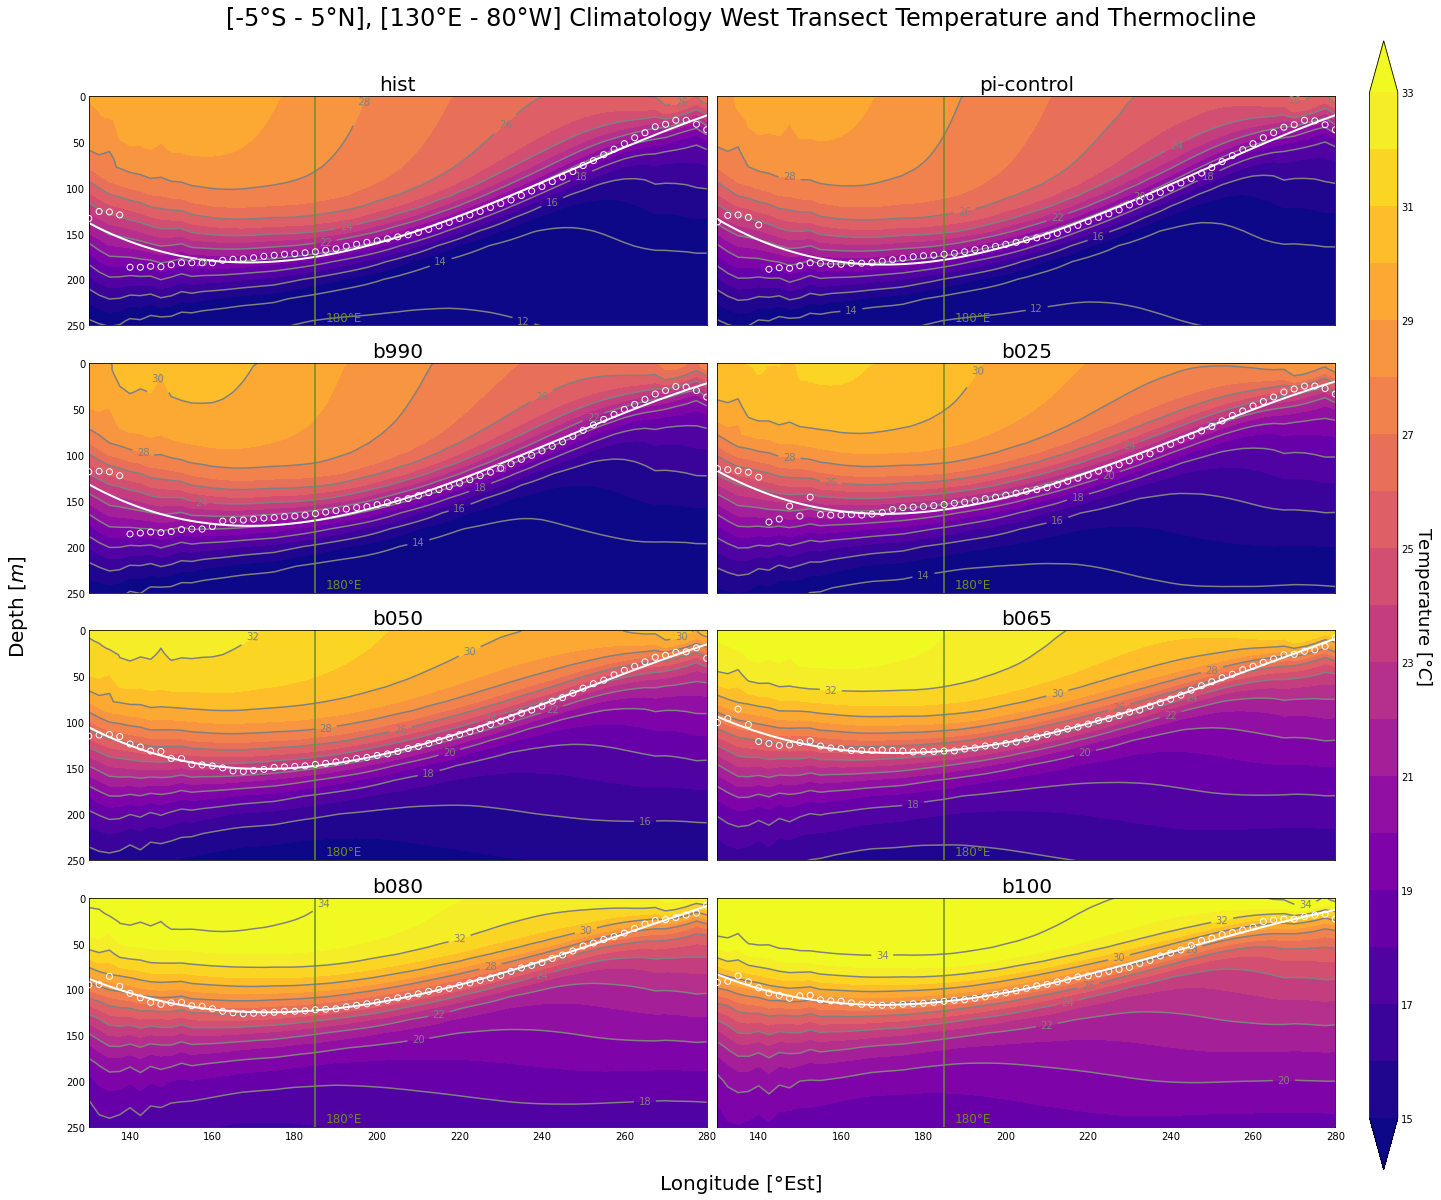

In [7]:
################################################################################################
################### Termoclina trasect plot [-5°S - 5°N] [130°E - 80°W] ########################
##################################### Fit Cubico ###############################################
################################### last 50 years ##############################################
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 16)) #(16, 8)

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f = np.arange(15, 34, 1).round(2)
levels = np.arange(12, 36, 2).round(2)
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

for i, datasetN in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   # Contour-plot data
   scalar = axs[row, col].contour(termo[i]['lon'], termo[i]['lev'], termo[i], levels=levels, colors='gray')
   thermocline = axs[row, col].plot(lon_ext, pol[i], color='white', linewidth=2, label='Thermocline')
   thermocline_scatter = axs[row, col].scatter(lon, lev_max_grad[i], marker='o', facecolors='none', edgecolors='white', zorder=10)
   # Add labels to line contours (specify the format)
   # fmt_func = lambda x,pos: "{:1.1f}".format(-x)
   # fmt = matplotlib.ticker.FuncFormatter(fmt_func)
   axs[row, col].clabel(scalar, inline=True, fontsize=10, fmt='%1.0f')
   # Contourf-plot data
   scalar_f = axs[row, col].contourf(termo[i]['lon'], termo[i]['lev'], termo[i], cmap='plasma', levels=levels_f, extend='both') # 'plasma', 'inferno', 'magma'
   # Set color for NaN
   plt.gca().set_facecolor("slategray")
   # Set a title for the axes.
   axs[row, col].set_title('{}'.format(datasetN), fontsize=20)
   #axs[row, col].set_xticklabels(ticks)
   axs[row, col].set_ylim(250, 0)
   # Set y-axis ticks number
   axs[row, col].set_yticks([0,50,100,150,200,250])
   if col == 1:
      axs[row, col].set_yticklabels("")
   if row != 3:
      axs[row, col].set_xticklabels("")

# Add color bar
cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
cbar.ax.set_ylabel('Temperature ' r'$[°C]$', fontsize=18, rotation=270, labelpad=20)

# Set axes options.
for ax in axs.flat:
   ax.axvline(termo[0]['lon'][22], color='olivedrab', linestyle='-')
   ax.text(termo[0]['lon'][23], termo[0]['lev'][32], '180°E', color='olivedrab', fontsize=12)
# Set Sup-stuff
fig.suptitle('[-5°S - 5°N], [130°E - 80°W] Climatology West Transect Temperature and Thermocline',  y=1.02, fontsize=24) #  y=1.02 for setting the distance of the suptitle from the figure
fig.supylabel('Depth 'r'$[m]$', fontsize=20, x=-0.01)
fig.supxlabel('Longitude [°Est]', fontsize=20, y=-0.01)
# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_7 + 'Clim_ThermoclinesFitCubic.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_7 + 'Clim_ThermoclinesFitCubic.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

/tmp/ipykernel_145081/3410956809.py:41: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
/tmp/ipykernel_145081/3410956809.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


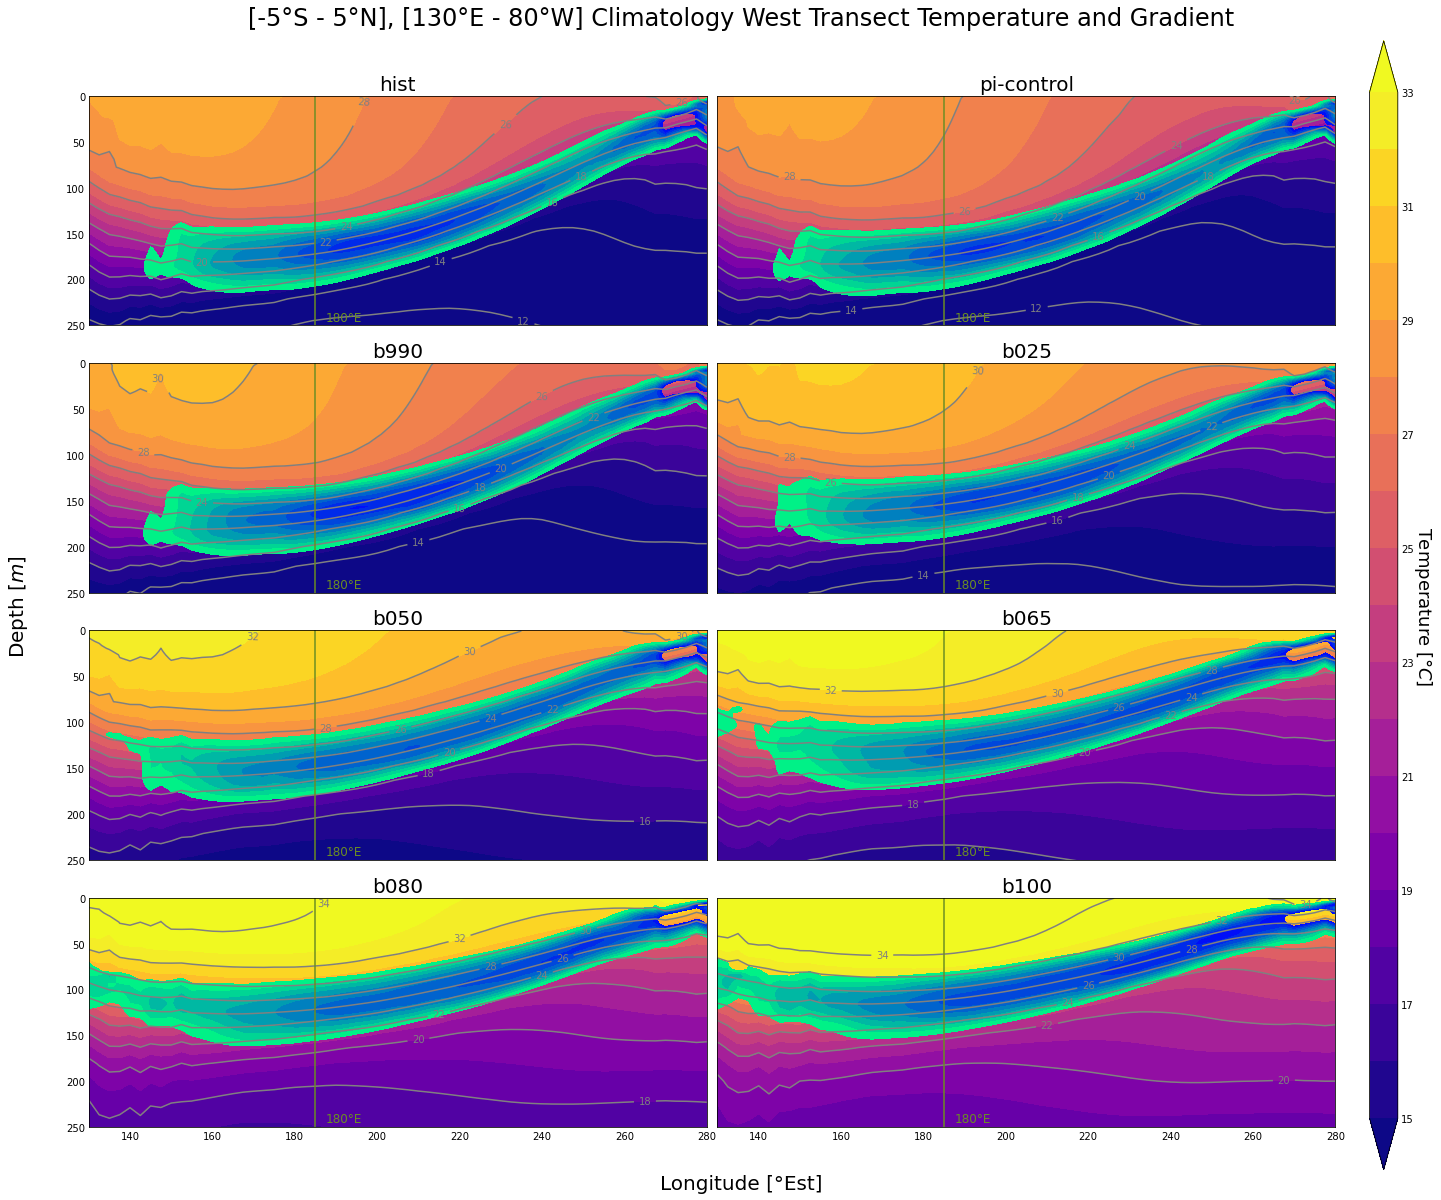

In [8]:
################################################################################################
########################## Termoclina trasect plot at 0°N 125E-80W #############################
################################### Contourf() Gradiente #######################################
###################################### last 50 years ###########################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 16))

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f = np.arange(15, 34, 1).round(2)
levels_f_termoclina = np.arange(-0.2, -0.1, 0.01)
levels = np.arange(12, 36, 2).round(2)
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

for i, datasetN in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   # Contour-plot data
   scalar = axs[row, col].contour(termo[i]['lon'], termo[i]['lev'], termo[i], levels=levels, colors='gray')
   # Add labels to line contours (specify the format)
   # fmt_func = lambda x,pos: "{:1.1f}".format(-x)
   # fmt = matplotlib.ticker.FuncFormatter(fmt_func)
   axs[row, col].clabel(scalar, inline=True, fontsize=10, fmt='%1.0f')
   # Contourf-plot data
   scalar_f = axs[row, col].contourf(termo[i]['lon'], termo[i]['lev'], termo[i], cmap='plasma', levels=levels_f, extend='both') # 'plasma', 'inferno', 'magma'
   scalar_f_thermocline = axs[row, col].contourf(dT_dlev[i].T['lon'], dT_dlev[i].T['lev'], dT_dlev[i].T, levels=levels_f_termoclina, cmap='winter')
   # Set color for NaN
   plt.gca().set_facecolor("slategray")
   # Set a title for the axes.
   axs[row, col].set_title('{}'.format(datasetN), fontsize=20)
   #axs[row, col].set_xticklabels(ticks)
   axs[row, col].set_ylim(250, 0)
   # Set y-axis ticks number
   axs[row, col].set_yticks([0,50,100,150,200,250])
   if col == 1:
      axs[row, col].set_yticklabels("")
   if row != 3:
      axs[row, col].set_xticklabels("")

# Add color bar
cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
cbar.ax.set_ylabel('Temperature ' r'$[°C]$', fontsize=18, rotation=270, labelpad=20)

# Set axes options.
for ax in axs.flat:
   ax.axvline(termo[0]['lon'][22], color='olivedrab', linestyle='-')
   ax.text(termo[0]['lon'][23], termo[0]['lev'][32], '180°E', color='olivedrab', fontsize=12)
# Set Sup-stuff
fig.suptitle('[-5°S - 5°N], [130°E - 80°W] Climatology West Transect Temperature and Gradient',  y=1.02, fontsize=24) #  y=1.02 for setting the distance of the suptitle from the figure
fig.supylabel('Depth 'r'$[m]$', fontsize=20, x=-0.01)
fig.supxlabel('Longitude [°Est]', fontsize=20, y=-0.01)
# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
# fig.savefig(common_Dir_home + dir_images_7 + 'Thermoclines.pdf', bbox_inches='tight')
# fig.savefig(common_Dir_home + dir_images_7 + 'Thermoclines.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

/tmp/ipykernel_145081/1580563035.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
/tmp/ipykernel_145081/1580563035.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


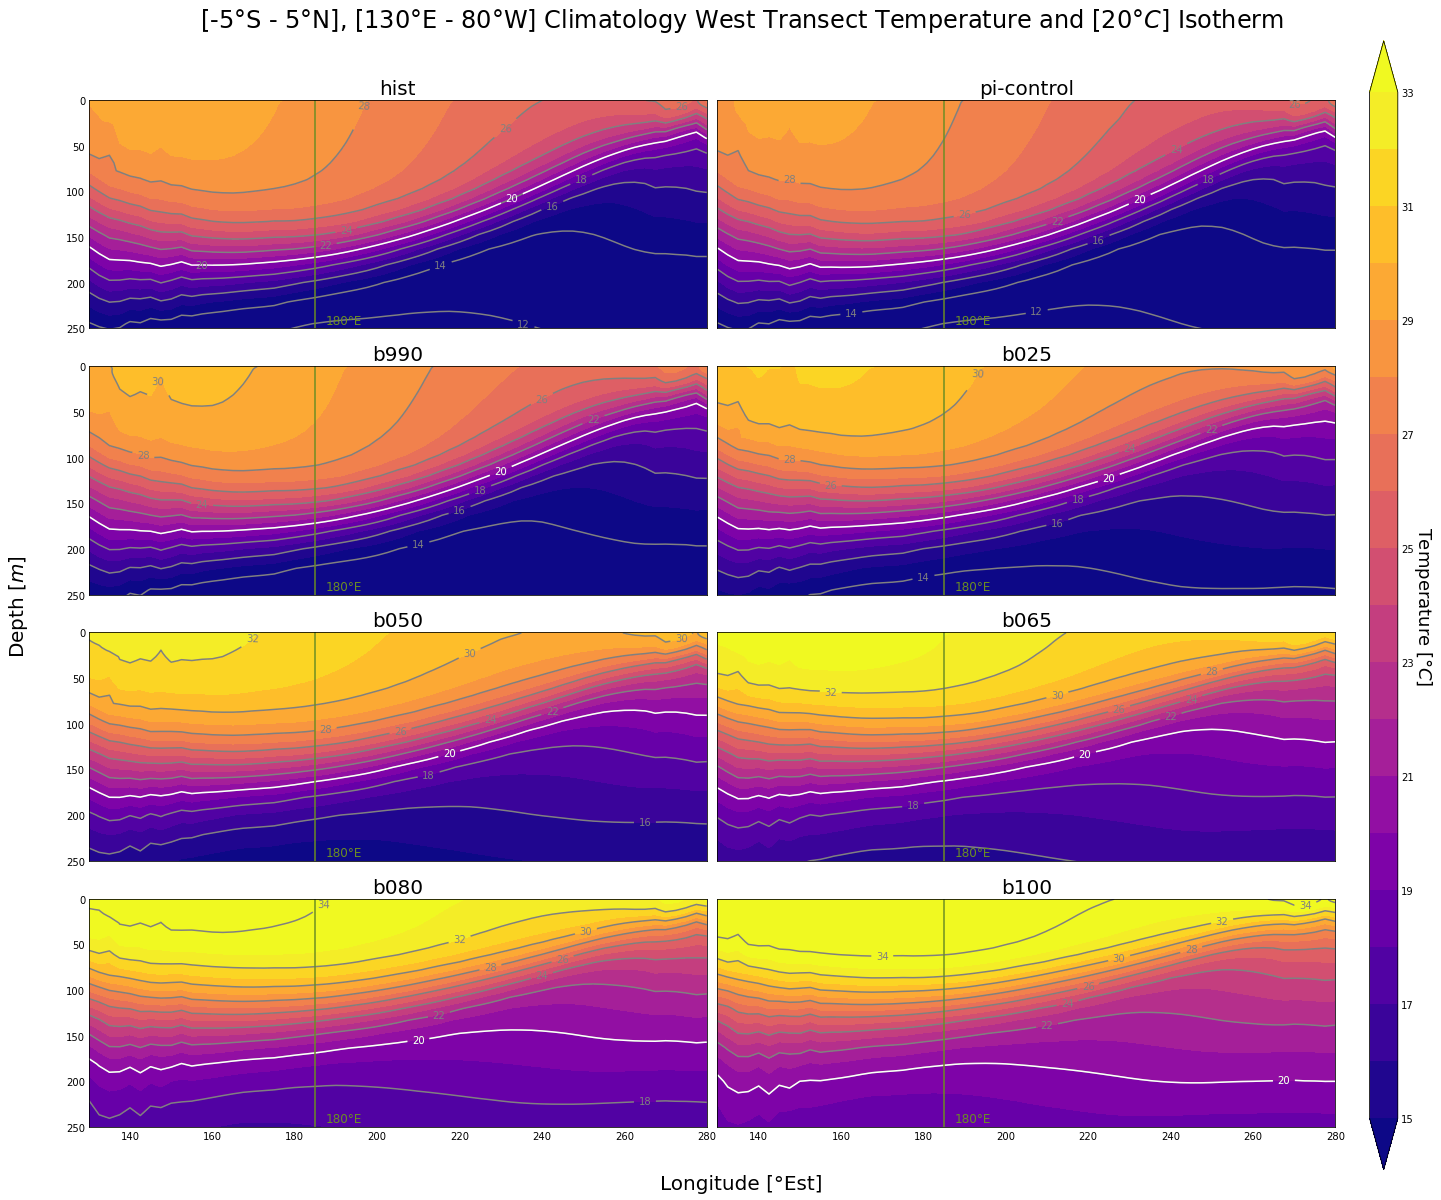

In [9]:
################################################################################################
########################## Thermocline trasect plot at 0°N 125E-80W ############################
###################################### Isoterma 20°C ###########################################
###################################### last 50 years ###########################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 16)) #(16, 8)

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f = np.arange(15, 34, 1).round(2)
levels = np.arange(12, 36, 2).round(2)
levelsA20 = np.arange(20, 20, 1)
levelsA20 = [20] # Level for the termoclina at 20°C
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

for i, datasetN in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   # Contour-plot data
   scalar = axs[row, col].contour(termo[i]['lon'], termo[i]['lev'], termo[i], levels=levels, colors='gray')
   scalar20 = axs[row, col].contour(termo[i]['lon'], termo[i]['lev'], termo[i], levels=[20], colors='white')
   # Add labels to line contours (specify the format)
   # fmt_func = lambda x,pos: "{:1.1f}".format(-x)
   # fmt = matplotlib.ticker.FuncFormatter(fmt_func)
   axs[row, col].clabel(scalar, inline=True, fontsize=10, fmt='%1.0f')
   axs[row, col].clabel(scalar20, inline=True, fontsize=10, fmt='%1.0f')
   # Contourf-plot data
   scalar_f = axs[row, col].contourf(termo[i]['lon'], termo[i]['lev'], termo[i], cmap='plasma', levels=levels_f, extend='both') # 'plasma', 'inferno', 'magma'
   # Set color for NaN
   plt.gca().set_facecolor("slategray")
   # Set a title for the axes.
   axs[row, col].set_title('{}'.format(datasetN), fontsize=20)
   #axs[row, col].set_xticklabels(ticks)
   axs[row, col].set_ylim(250, 0)
   # Set y-axis ticks number
   axs[row, col].set_yticks([0,50,100,150,200,250])
   if col == 1:
      axs[row, col].set_yticklabels("")
   if row != 3:
      axs[row, col].set_xticklabels("")

# Add color bar
cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.13)
cbar.ax.set_ylabel('Temperature ' r'$[°C]$', fontsize=18, rotation=270, labelpad=20)

# Set axes options.
for ax in axs.flat:
   ax.axvline(termo[0]['lon'][22], color='olivedrab', linestyle='-')
   ax.text(termo[0]['lon'][23], termo[0]['lev'][32], '180°E', color='olivedrab', fontsize=12)
# Set Sup-stuff
fig.suptitle('[-5°S - 5°N], [130°E - 80°W] Climatology West Transect Temperature and 'r'$[20°C]$'' Isotherm',  y=1.02, fontsize=24) #  y=1.02 for setting the distance of the suptitle from the figure
fig.supylabel('Depth 'r'$[m]$', fontsize=20, x=-0.01)
fig.supxlabel('Longitude [°Est]', fontsize=20, y=-0.01)
# # Set color for NaN --> Serve anche come maschera continentale
# plt.gca().set_facecolor("slategray")  
# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_7 + 'Clim_Thermoclines20C.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_7 + 'Clim_Thermoclines20C.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

In [15]:
# Estremi transetto temperatura durante El Nino
for datasetN in dataset_names:
   min, max = np.min(composite['nino']['thetao'][datasetN]), np.max(composite['nino']['thetao'][datasetN])
   print(f'Min e Max Nino {datasetN}',min.values.round(2), max.values.round(2))

Min e Max Nino hist -1.51 1.76
Min e Max Nino pi-control -0.47 0.28
Min e Max Nino b990 -1.35 1.85
Min e Max Nino b025 -1.91 2.58
Min e Max Nino b050 -2.33 2.96
Min e Max Nino b065 -2.15 2.57
Min e Max Nino b080 -1.8 2.3
Min e Max Nino b100 -1.78 2.07


/tmp/ipykernel_183928/430322767.py:56: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.15)
/tmp/ipykernel_183928/430322767.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


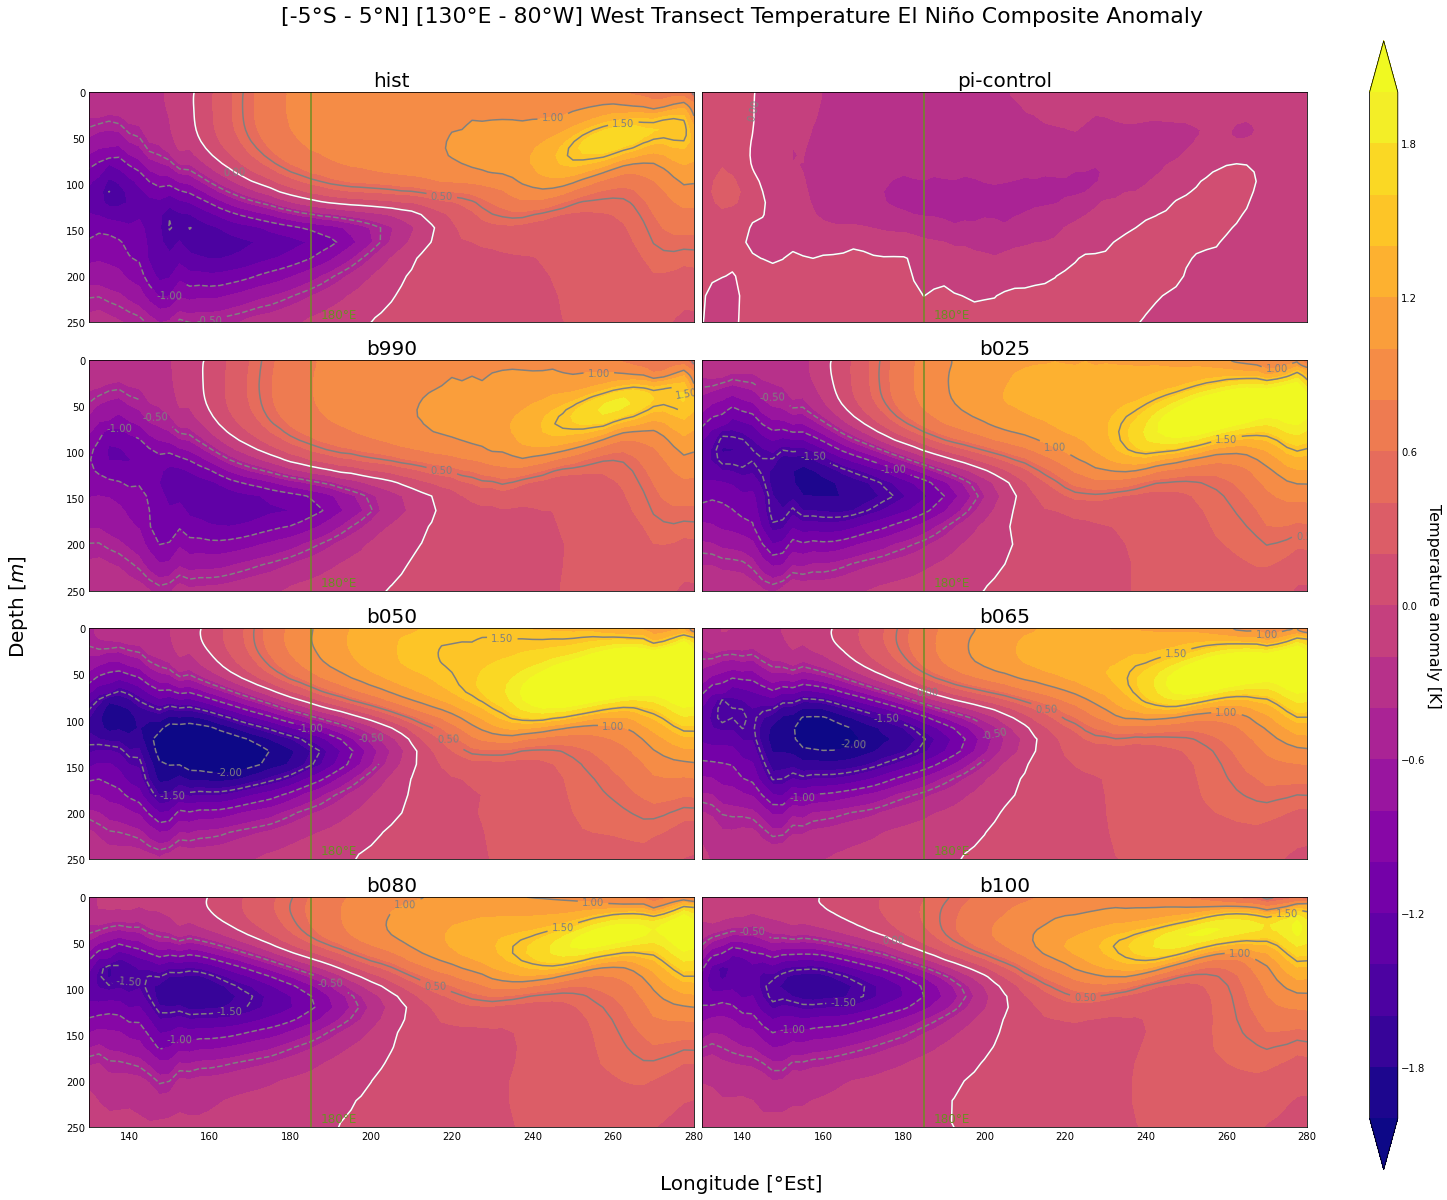

In [6]:
################################################################################################
######################## Thermocline Composite trasect plot at 0°N 125E-80W ####################
######################################### last 50 years ########################################
############################################# Nino #############################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 16)) #(16, 8)

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f = np.linspace(-2, 2, 21).round(2)
levels = np.arange(-2, 2, 0.5).round(1)
levels0 = [0] # Level for the termoclina at 20°C
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

# Dictionary keys
phase = 'nino'
var = 'thetao'
for i, datasetN in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   # Contour-plot data
   scalar=axs[row, col].contour(
      composite[phase][var][datasetN]['lon'],
      composite[phase][var][datasetN]['lev'],
      composite[phase][var][datasetN],
      levels=levels, colors='gray')
   scalar20=axs[row, col].contour(
      composite[phase][var][datasetN]['lon'],
      composite[phase][var][datasetN]['lev'],
      composite[phase][var][datasetN],
      levels=levels0, colors='white')
   # Add labels to line contours (specify the format)
   #fmt_func = lambda x,pos: "{:1.1f}".format(-x) #
   #fmt = matplotlib.ticker.FuncFormatter(fmt_func) #
   axs[row, col].clabel(scalar, inline=True, fontsize=10, fmt='%1.2f')
   # Contourf-plot data
   scalar_f = axs[row, col].contourf(
      composite[phase][var][datasetN]['lon'],
      composite[phase][var][datasetN]['lev'],
      composite[phase][var][datasetN],
      cmap='plasma', levels=levels_f, extend='both') # 'plasma', 'inferno', 'magma'
   # Set color for NaN
   plt.gca().set_facecolor("slategray")
   # Set a title for the axes.
   axs[row, col].set_title('{}'.format(datasetN), fontsize=20)
   #axs[row, col].set_xticklabels(ticks)
   axs[row, col].set_ylim(250, 0)
   # Set y-axis ticks number
   axs[row, col].set_yticks([0,50,100,150,200,250])
   if col == 1:
      axs[row, col].set_yticklabels("")
   if row != 3:
      axs[row, col].set_xticklabels("")

# Add color bar
cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.15)
cbar.ax.set_ylabel('Temperature anomaly 'r'[K]', fontsize=16, rotation=270, labelpad=15)

# Set axes options.
for ax in axs.flat:
   ax.axvline(composite[phase][var][datasetN]['lon'][22], color='olivedrab', linestyle='-')
   ax.text(composite[phase][var][datasetN]['lon'][23], composite[phase][var][datasetN]['lev'][32], '180°E', color='olivedrab', fontsize=12)
# Set Sup-stuff
fig.suptitle('[-5°S - 5°N] [130°E - 80°W] West Transect Temperature El Niño Composite Anomaly',  y=1.02, fontsize=22) #  y=1.02 for setting the distance of the suptitle from the figure
fig.supylabel('Depth 'r'$[m]$', fontsize=20, x=-0.01)
fig.supxlabel('Longitude [°Est]', fontsize=20, y=-0.01)
# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_8 + 'Transect_CompositeNino.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_8 + 'Transect_CompositeNino.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()


Commento:
- dalla versione precedete non cambia sostanzialmente molto. Questo bene, significa che non avevo commesso grossi errori e ora ho solo affinato il tiro.
- Il pi-control rimane un mistero... non ho idea del perchè sia così differente dagli altri. (idem versione precedente)
- (i) la quota della bolola di raffreddamento risale verso superficie progressivamente con l'aumento del riscaldamento: dai 150m di storico e b990 si passa ai ~100 del b100. La quota del riscaldamento invece non sembra subire modifiche nella quota significative, ma
- (ii) entrambi i pattern di riscaldamento/raffreddamento si modificano e mostrano un'inversione di tendenza, tra b050 e b065 con b080 e b100. Il raffreddamento della warm pool cresce come estensione ed intensità del raffreddamento fino a tra il b050 e il b065, per poi diminuire dal b080; il riscaldamento della cold tongue si espande nell'intensità ed estensione del suo massimo verso Ovest (ma anche verso la dimensione verticale) fino al b050, dal b065 inizia a contrarsi e ritirarsi.

In [16]:
# Estremi transetto temperatura durante El Nino
for datasetN in dataset_names:
   min, max = np.min(composite['nina']['thetao'][datasetN]), np.max(composite['nina']['thetao'][datasetN])
   print(f'Min e Max Nina {datasetN}',min.values.round(2), max.values.round(2))

Min e Max Nina hist -1.46 1.16
Min e Max Nina pi-control -0.22 0.61
Min e Max Nina b990 -1.63 1.04
Min e Max Nina b025 -2.06 1.39
Min e Max Nina b050 -2.52 1.69
Min e Max Nina b065 -2.04 1.68
Min e Max Nina b080 -2.33 1.93
Min e Max Nina b100 -2.03 1.74


/tmp/ipykernel_183928/856563993.py:56: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.15)
/tmp/ipykernel_183928/856563993.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


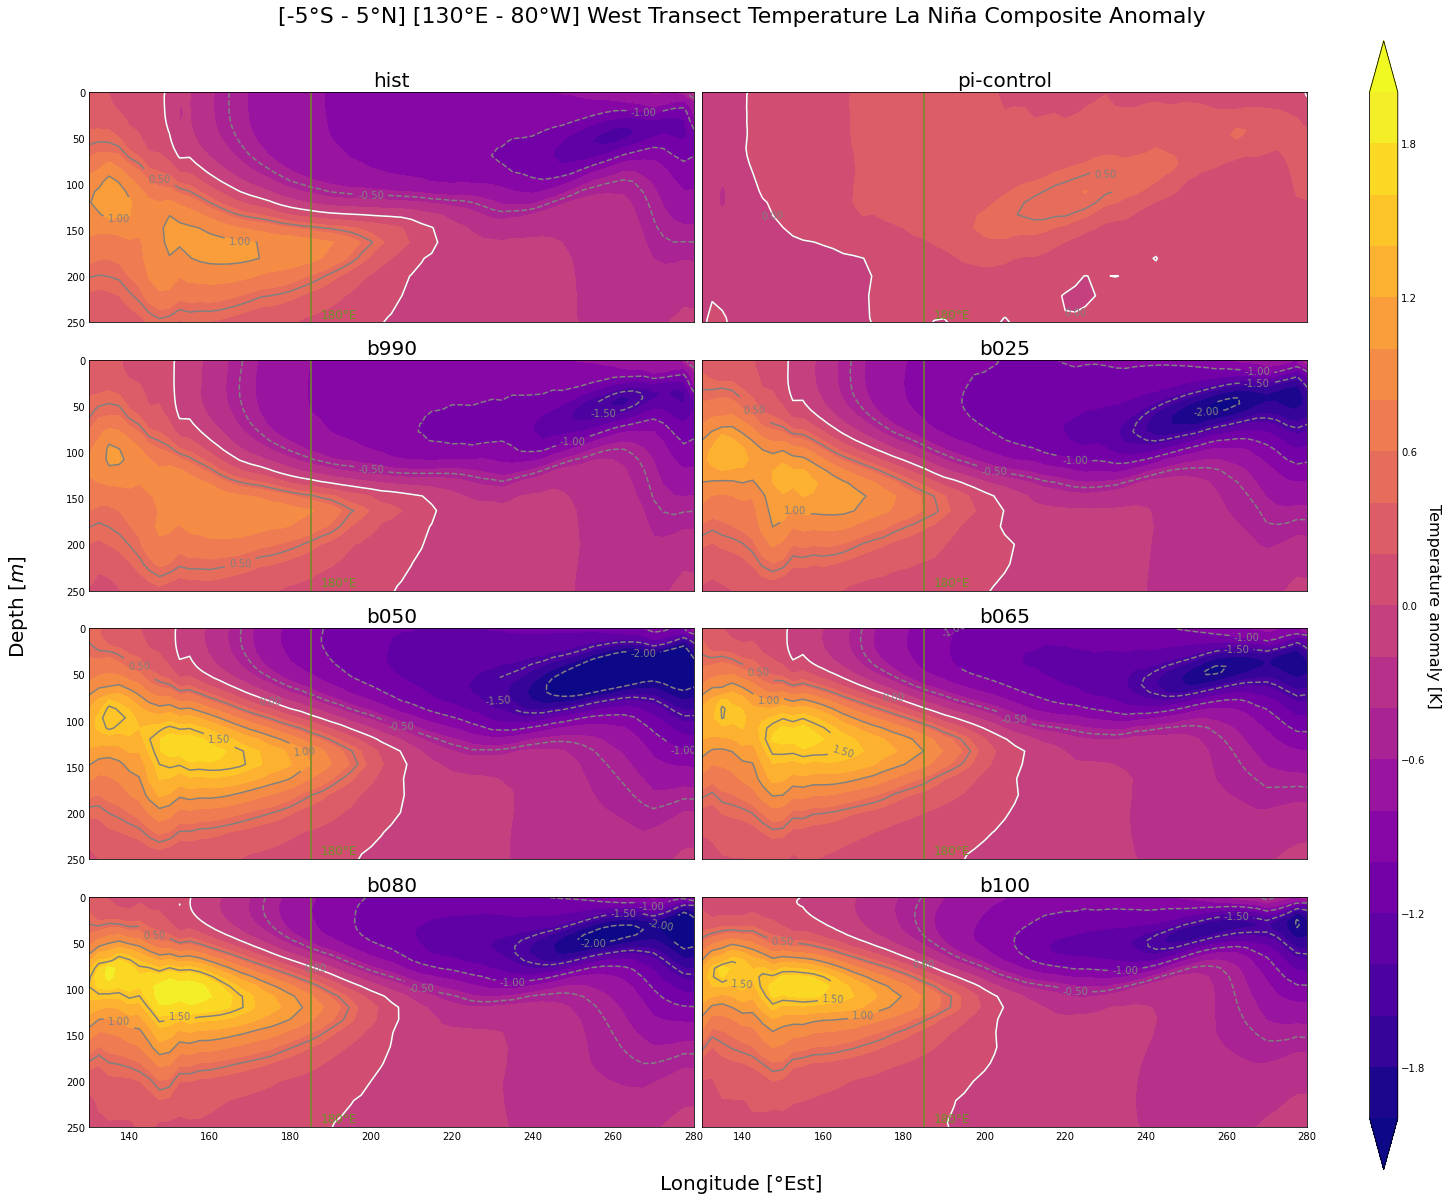

In [7]:
################################################################################################
######################## Thermocline Composite trasect plot at 0°N 125E-80W ####################
######################################### last 50 years ########################################
############################################# Nino #############################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 16)) #(16, 8)

# Levels of plot ( _f per il 'contourf', normali per il 'contour')
levels_f = np.linspace(-2, 2, 21).round(2)
levels = np.arange(-2, 2, 0.5).round(1)
levels0 = [0] # Level for the termoclina at 20°C
#ticks = ["130E", "160E", "170W", "140W", "110W", "80W"]

# Dictionary keys
phase = 'nina'
var = 'thetao'
for i, datasetN in enumerate(dataset_names):
   row = i // 2
   col = i % 2
   # Contour-plot data
   scalar=axs[row, col].contour(
      composite[phase][var][datasetN]['lon'],
      composite[phase][var][datasetN]['lev'],
      composite[phase][var][datasetN],
      levels=levels, colors='gray')
   scalar20=axs[row, col].contour(
      composite[phase][var][datasetN]['lon'],
      composite[phase][var][datasetN]['lev'],
      composite[phase][var][datasetN],
      levels=levels0, colors='white')
   # Add labels to line contours (specify the format)
   #fmt_func = lambda x,pos: "{:1.1f}".format(-x) #
   #fmt = matplotlib.ticker.FuncFormatter(fmt_func) #
   axs[row, col].clabel(scalar, inline=True, fontsize=10, fmt='%1.2f')
   # Contourf-plot data
   scalar_f = axs[row, col].contourf(
      composite[phase][var][datasetN]['lon'],
      composite[phase][var][datasetN]['lev'],
      composite[phase][var][datasetN],
      cmap='plasma', levels=levels_f, extend='both') # 'plasma', 'inferno', 'magma'
   # Set color for NaN
   plt.gca().set_facecolor("slategray")
   # Set a title for the axes.
   axs[row, col].set_title('{}'.format(datasetN), fontsize=20)
   #axs[row, col].set_xticklabels(ticks)
   axs[row, col].set_ylim(250, 0)
   # Set y-axis ticks number
   axs[row, col].set_yticks([0,50,100,150,200,250])
   if col == 1:
      axs[row, col].set_yticklabels("")
   if row != 3:
      axs[row, col].set_xticklabels("")

# Add color bar
cbar = plt.colorbar(scalar_f, ax=axs, orientation='vertical', aspect=40, fraction=0.055, pad=-0.15)
cbar.ax.set_ylabel('Temperature anomaly 'r'[K]', fontsize=16, rotation=270, labelpad=15)

# Set axes options.
for ax in axs.flat:
   ax.axvline(composite[phase][var][datasetN]['lon'][22], color='olivedrab', linestyle='-')
   ax.text(composite[phase][var][datasetN]['lon'][23], composite[phase][var][datasetN]['lev'][32], '180°E', color='olivedrab', fontsize=12)
# Set Sup-stuff
fig.suptitle('[-5°S - 5°N] [130°E - 80°W] West Transect Temperature La Niña Composite Anomaly',  y=1.02, fontsize=22) #  y=1.02 for setting the distance of the suptitle from the figure
fig.supylabel('Depth 'r'$[m]$', fontsize=20, x=-0.01)
fig.supxlabel('Longitude [°Est]', fontsize=20, y=-0.01)
# Set axis thick labels
plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_8 + 'Transect_CompositeNina.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_8 + 'Transect_CompositeNina.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()


Commento:
- Anche qua come la versione precedete non cambia sostanzialmente molto.
- Stesso discorso per il Pi-control

Vale un pò lo stesso discorso che nel caso nino ma al contrario, tuttavia ci sono delle differenze. 
- (i) La cold tongue come nel caso precedente subisce una variaizione dell'intensità del raffreddamento come caratteristica principale: esso aumenta fino al b050 (anche se il b080 mostra anchesso minimi comparabili) poi ha un'inversione di tendenza, accennata dal b065, non confermata appunto dal b080 ma confermata dal b100 che decresce. La quota della bolola non subisce sostanziali variaizioni, ma la sua dimensione (superficie) segue lo stesso trend, con il b100 avente un'estensione specialmente verticale molto assottigliata rispetto lo storico. Inoltre si modifica, anche se in misura minore che la warm pool (come nel caso precedente), l'estensione zonale, che anch'essa come intensità e spessore (superficie in altre parole) si espande verso Ovest fino al b050 per poi ritirarsi dal b065. 
- (ii) La warm pool aumenta progressivamente l'intensità del suo riscaldamento, fino al b080 (il b100 mostra un'inversione) e come nel caso precedente il centro del suo riscaldamento risale verso superficie di circa 50m tra tutti i run. La sua forma, a differenza della cold tongue, e come nel caso precedente non si modifica in modo marcato, la cold tongue in questo modifica molto maggiormente la sua forma ed estensione. Come nel caso precedete tende ad ingrossarsi espandendosi soprattutto verso Est (più che verso il basso/alto), il trend è progressivo fino al b065 circa poi ha un debole accenno di contrazione.

Differenze
- Il raffreddamento della warm pool durante El Nino si ritira in misura maggiore di quanto non faccia il riscaldamento durante la Nina (soprattutto nell'espansione verso Est)


/tmp/ipykernel_145081/22573132.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)#, y=-0.02)


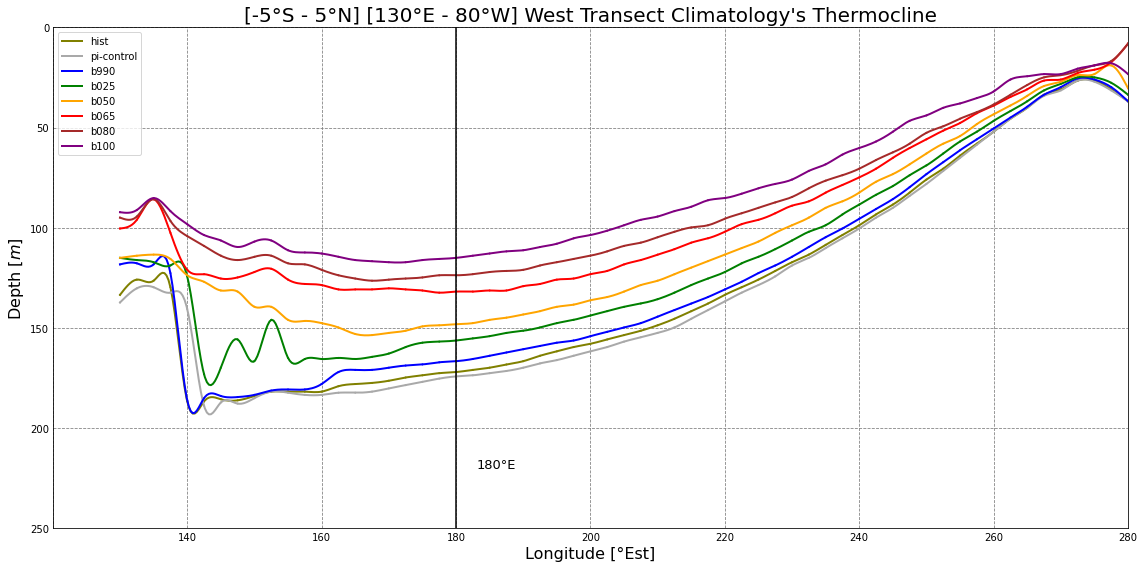

In [ ]:
################################################################################################
############# [-5°S - 5°N] [130°E - 80°W] West Transect Climatology's Thermocline ##############
################################### CubicSpline Interpolation ##################################
######################################### last 50 years ########################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(16, 8))

# Levels of plot
levels20 = [20] # Level for the termoclina at 20°C
ticks = ["", "140", "160", "180", "200", "220", "240", "260", "280"]

# Contour-plot data
for i, datasetN in enumerate(dataset_names):
   thermocline = ax.plot(lon_ext, cubic_spline[i](lon_ext), color=colors[i], linewidth=2, label=datasetN)
   thermocline_scatter = ax.scatter(lon, lev_max_grad[i], marker='o', facecolors='none', edgecolors=colors[i], s=1)
   ax.legend(loc = 'upper left')
# import matplotlib.patches as mpatches
# 'fake' invisible object creation for legend
# patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]
# Set a legend
# ax.legend(patches, dataset_names, loc = 'upper right')
# Set axes options.
ax.set_title('[-5°S - 5°N] [130°E - 80°W] West Transect Climatology\'s Thermocline', fontsize=20)
ax.set_xlabel('Longitude [°Est]', fontsize=16)
ax.set_ylabel('Depth 'r'$[m]$', fontsize=16)
ax.set_ylim(250, 0)
#ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(120, 280)
ax.set_xticklabels(ticks)#, y=-0.02)
ax.grid(linestyle='--', color='gray')
ax.axvline(180, color='k', linestyle='-')
ax.text(183, 220, '180°E', color='k', fontsize=13)

plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_7 + 'Thermocline-InterpSplineCubic.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_7 + 'Thermocline-InterpSplineCubic.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

/tmp/ipykernel_145081/3230597433.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)#, y=-0.02)


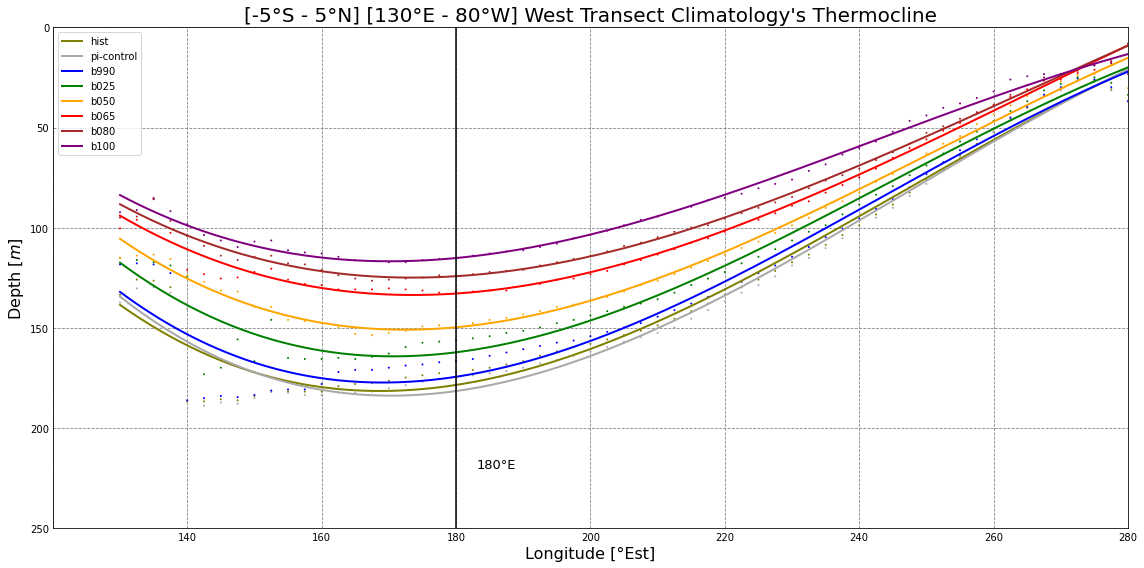

In [ ]:
################################################################################################
############# [-5°S - 5°N] [130°E - 80°W] West Transect Climatology's Thermocline ##############
########################################### Cubic Fit ##########################################
######################################### last 50 years ########################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(16, 8))

# Levels of plot
levels20 = [20] # Level for the termoclina at 20°C
ticks = ["", "140", "160", "180", "200", "220", "240", "260", "280"]

# Contour-plot data
for i, datasetN in enumerate(dataset_names):
   thermocline = ax.plot(lon_ext, pol[i], color=colors[i], linewidth=2, label=datasetN)
   thermocline_scatter = ax.scatter(lon, lev_max_grad[i], marker='o', facecolors='none', edgecolors=colors[i], s=1)
   ax.legend(loc = 'upper left')
# import matplotlib.patches as mpatches
# 'fake' invisible object creation for legend
# patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]
# Set a legend
# ax.legend(patches, dataset_names, loc = 'upper right')
# Set axes options.
ax.set_title('[-5°S - 5°N] [130°E - 80°W] West Transect Climatology\'s Thermocline', fontsize=20)
ax.set_xlabel('Longitude [°Est]', fontsize=16)
ax.set_ylabel('Depth 'r'$[m]$', fontsize=16)
ax.set_ylim(250, 0)
#ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(120, 280)
ax.set_xticklabels(ticks)#, y=-0.02)
ax.grid(linestyle='--', color='gray')
ax.axvline(180, color='k', linestyle='-')
ax.text(183, 220, '180°E', color='k', fontsize=13)

plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_7 + 'Thermocline-FitCubic.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_7 + 'Thermocline-FitCubic.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

Commento:
- Nei fit cubici (in generale nell'andamento della termoclina) il trend è quello di aumentare l'ampiezza della concavità della cubica (ha una pancia più grossa) fino alla fine.
- La termoclina continua a sollevarsi verso superficie, c'è un incremento della velocità tra b025 e b065 per poi rallentare dal b080.
Nota: Non noto nessuna inversione di tendenza tra i run. Nella versione precedente c'era un'inversione di tendenza: dal b80-b100 al b065, la concavità si riduce "richiudendosi"

/tmp/ipykernel_156419/2621908548.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)#, y=-0.02)


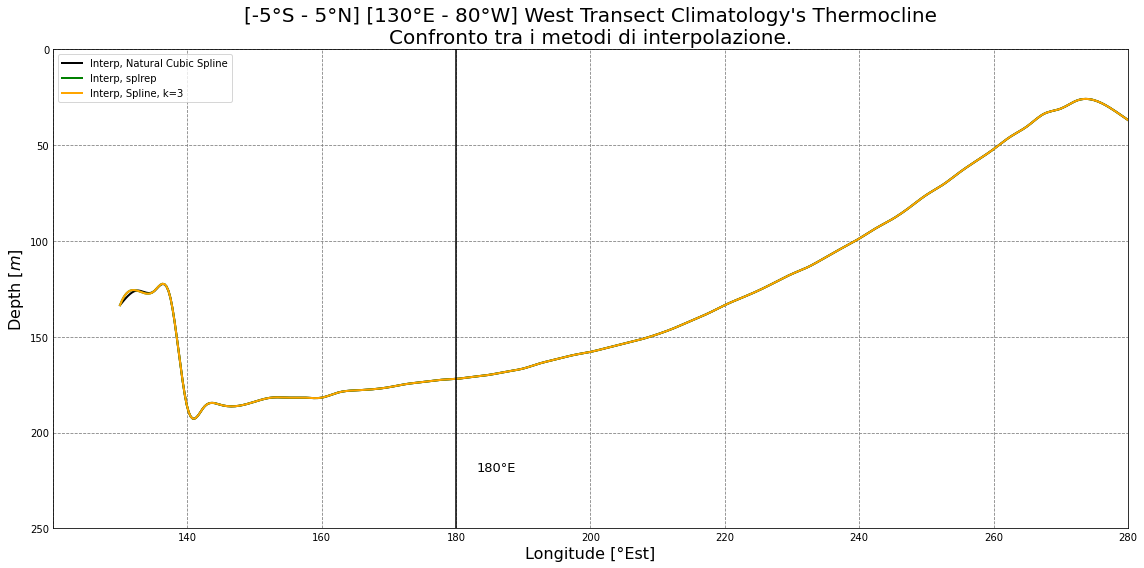

In [ ]:
################################################################################################
############# [-5°S - 5°N] [130°E - 80°W] West Transect Climatology's Thermocline ##############
############################ Confronto tra i metodi di interpolazione ##########################
######################################### last 50 years ########################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(16, 8))

# Levels of plot
levels20 = [20] # Level for the termoclina at 20°C
ticks = ["", "140", "160", "180", "200", "220", "240", "260", "280"]

# Contour-plot data
thermocline = ax.plot(lon_ext, cubic_spline[0](lon_ext), color='k', linewidth=2, label='Interp Natural Cubic Spline, \'cubicspline\'')
thermocline = ax.plot(lon_ext, spline_interp[0], color='g', linewidth=2, label='Interp Spline, \'splrep\', k=3')
thermocline = ax.plot(lon_ext, lev_interp[0], color='orange', linewidth=2, label='Interp, \'interp1d\'')
ax.legend(loc = 'upper left')
# import matplotlib.patches as mpatches
# 'fake' invisible object creation for legend
# patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]
# Set a legend
# ax.legend(patches, dataset_names, loc = 'upper right')
# Set axes options.
ax.set_title('[-5°S - 5°N] [130°E - 80°W] West Transect Climatology\'s Thermocline\nConfronto tra i metodi di interpolazione', fontsize=20)
ax.set_xlabel('Longitude [°Est]', fontsize=16)
ax.set_ylabel('Depth 'r'$[m]$', fontsize=16)
ax.set_ylim(250, 0)
#ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlim(120, 280)
ax.set_xticklabels(ticks)#, y=-0.02)
ax.grid(linestyle='--', color='gray')
ax.axvline(180, color='k', linestyle='-')
ax.text(183, 220, '180°E', color='k', fontsize=13)

plt.tight_layout()
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

/tmp/ipykernel_145081/1764046414.py:14: UserWarning: The following kwargs were not used by contour: 'labels'
  scalar20 = ax.contour(termo[i]['lon'], termo[i]['lev'], termo[i], levels=levels20, labels=datasetN, colors=colors[i])


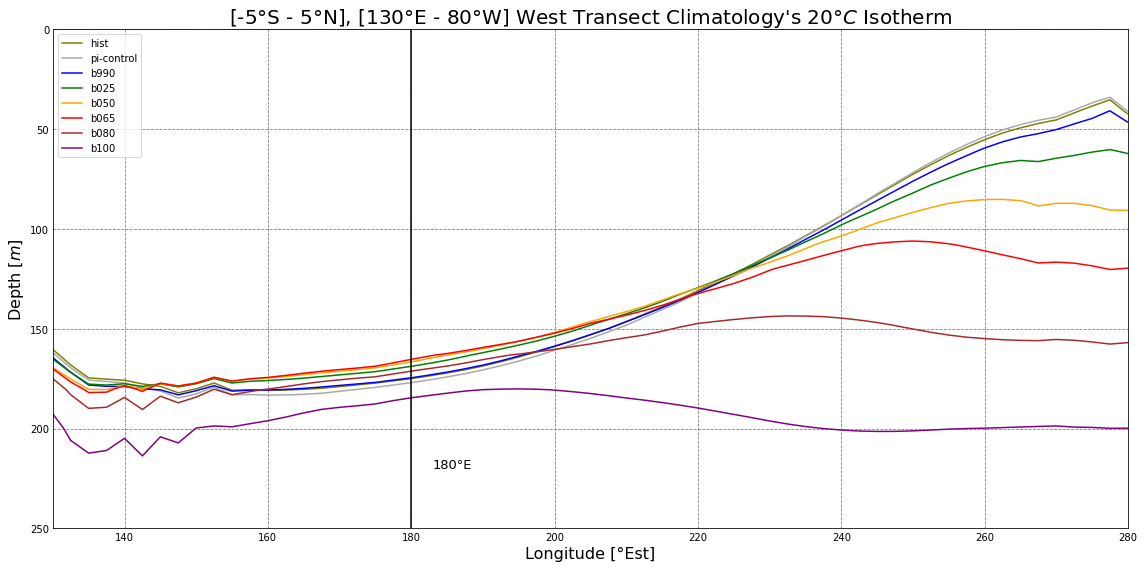

In [ ]:
################################################################################################
############ [-5°S - 5°N] [130°E - 80°W] West Transect Climatology's 20°C isotherm #############
######################################### last 50 years ########################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(16, 8))

# Levels of plot
levels20 = [20] # Level for the termoclina at 20°C
#ticks = ["170W", "160W", "150W", "140W", "130W", "120W", "110W"]

# Contour-plot data
for i, datasetN in enumerate(dataset_names):
   scalar20 = ax.contour(termo[i]['lon'], termo[i]['lev'], termo[i], levels=levels20, labels=datasetN, colors=colors[i])
   ax.plot(180, 180, color=colors[i], label=datasetN) # Fake plot per associare le labels per la legend, il contour dà problemi 
   ax.legend(loc = 'upper left')
# import matplotlib.patches as mpatches
# 'fake' invisible object creation for legend
# patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]
# Set a legend
# ax.legend(patches, dataset_names, loc = 'upper right')
# Set axes options.
ax.set_title('[-5°S - 5°N], [130°E - 80°W] West Transect Climatology\'s 'r'$20°C$'' Isotherm', fontsize=20)
ax.set_xlabel('Longitude [°Est]', fontsize=16)
ax.set_ylabel('Depth 'r'$[m]$', fontsize=16)
ax.set_ylim(250, 0)
#ax.set_ylim(ax.get_ylim()[::-1])
#ax.set_xticklabels(ticks, y=-0.02)
ax.grid(linestyle='--', color='gray')
ax.axvline(180, color='k', linestyle='-')
ax.text(183, 220, '180°E', color='k', fontsize=13)

plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_7 + 'Isotherm-20C.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_7 + 'Isotherm-20C.jpg', bbox_inches='tight', dpi=150)
# Chiusura immagine
plt.close()

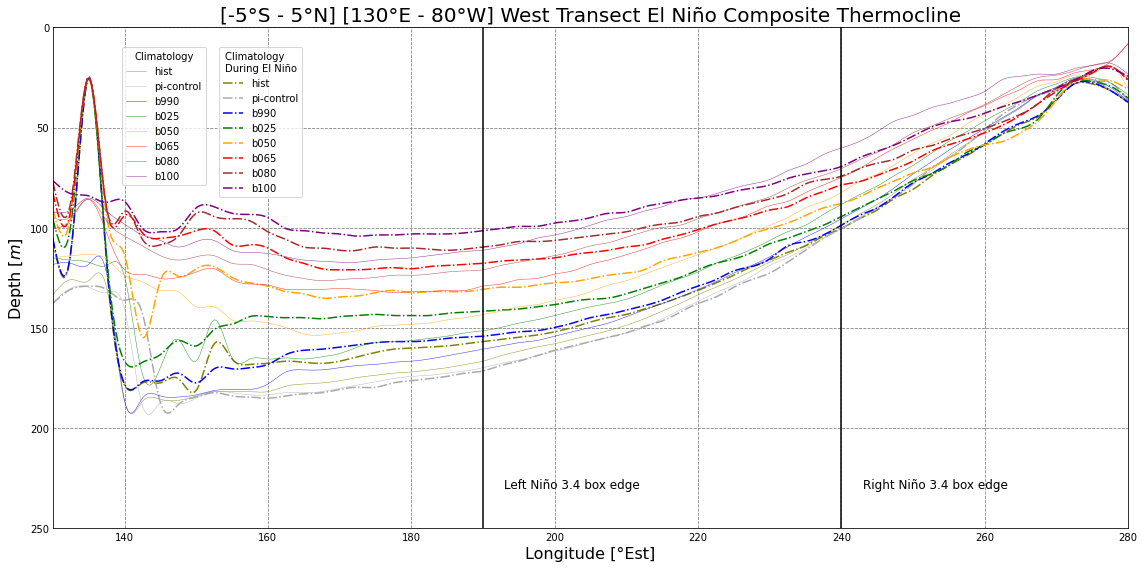

In [ ]:
################################################################################################
############## [-5°S - 5°N] [130°E - 80°W] Thermocline + El Nino Anlomaly Composite ############
######################################### last 50 years ########################################
########################################### Nino ###############################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(16, 8))

for i, datasetN in enumerate(dataset_names):
   thermocline = ax.plot(lon_ext, cubic_spline[i](lon_ext), color=colors[i], label=datasetN, linewidth=0.5, alpha=0.8)
   thermocline_nino = ax.plot(lon_ext, cubic_spline_nino[i](lon_ext), color=colors[i], label=datasetN, linestyle='-.')
 
# Legends
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::2], labels[::2], title='Climatology', loc='upper left', bbox_to_anchor=(0.06, 0.97))
ax.add_artist(legend)
legend_nino = ax.legend(handles[1::2], labels[1::2], title='Climatology \nDuring El Niño', loc='upper left', bbox_to_anchor=(0.15, 0.97))

# import matplotlib.patches as mpatches
# 'fake' invisible object creation for legend
#patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]
# Set a legend
#ax.legend(patches, dataset_names, loc = 'upper right')

# Set axes options.
ax.set_title('[-5°S - 5°N] [130°E - 80°W] West Transect El Niño Composite Thermocline', fontsize=20)
ax.set_xlabel('Longitude [°Est]', fontsize=16)
ax.set_ylabel('Depth 'r'$[m]$', fontsize=16)
ax.set_ylim(250, 0)
# Set y-axis ticks number
ax.set_yticks([0,50,100,150,200,250])
ax.set_xlim(130, 280)
#ax.set_ylim(ax.get_ylim()[::-1])
#ax.set_xticklabels(ticks, y=-0.02)
ax.grid(linestyle='--', color='gray')
ax.axvline(190, color='black', linestyle='-')
ax.text(193, 230, 'Left Niño 3.4 box edge', color='black', fontsize=12)
ax.axvline(240, color='black', linestyle='-')
ax.text(243, 230, 'Right Niño 3.4 box edge', color='black', fontsize=12)

plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_8 + 'Thermocline_CompositeNino.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_8 + 'Thermocline_CompositeNina.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

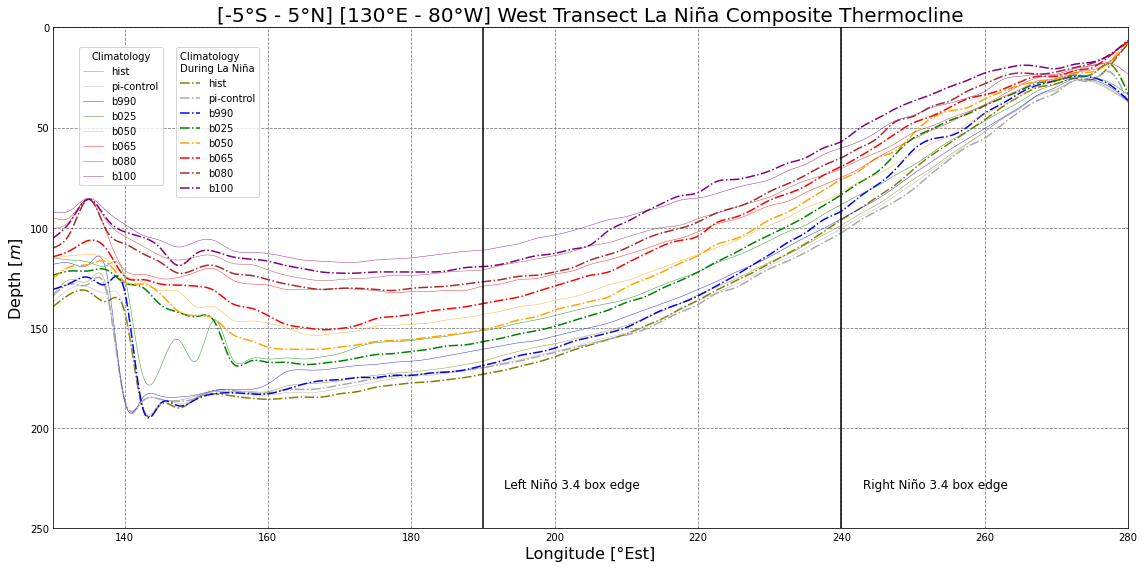

In [ ]:
################################################################################################
############## [-5°S - 5°N] [130°E - 80°W] Thermocline + La Nina Anlomaly Composite ############
######################################### last 50 years ########################################
########################################### Nino ###############################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(16, 8))

phase = 'nino'
var = 'thetao'

for i, datasetN in enumerate(dataset_names):
   thermocline = ax.plot(lon_ext, cubic_spline[i](lon_ext), color=colors[i], label=datasetN, linewidth=0.5, alpha=0.8)
   thermocline_nino = ax.plot(lon_ext, cubic_spline_nina[i](lon_ext), color=colors[i], label=datasetN, linestyle='-.')
 
# Legends
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::2], labels[::2], title='Climatology', loc='upper left', bbox_to_anchor=(0.02, 0.97))
ax.add_artist(legend)
legend_nino = ax.legend(handles[1::2], labels[1::2], title='Climatology \nDuring La Niña', loc='upper left', bbox_to_anchor=(0.11, 0.97))

# import matplotlib.patches as mpatches
# 'fake' invisible object creation for legend
#patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]
# Set a legend
#ax.legend(patches, dataset_names, loc = 'upper right')

# Set axes options.
ax.set_title('[-5°S - 5°N] [130°E - 80°W] West Transect La Niña Composite Thermocline', fontsize=20)
ax.set_xlabel('Longitude [°Est]', fontsize=16)
ax.set_ylabel('Depth 'r'$[m]$', fontsize=16)
ax.set_ylim(250, 0)
# Set y-axis ticks number
ax.set_yticks([0,50,100,150,200,250])
ax.set_xlim(130, 280)
#ax.set_ylim(ax.get_ylim()[::-1])
#ax.set_xticklabels(ticks, y=-0.02)
ax.grid(linestyle='--', color='gray')
ax.axvline(190, color='black', linestyle='-')
ax.text(193, 230, 'Left Niño 3.4 box edge', color='black', fontsize=12)
ax.axvline(240, color='black', linestyle='-')
ax.text(243, 230, 'Right Niño 3.4 box edge', color='black', fontsize=12)

plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_8 + 'Thermocline_CompositeNina.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_8 + 'Thermocline_CompositeNina.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

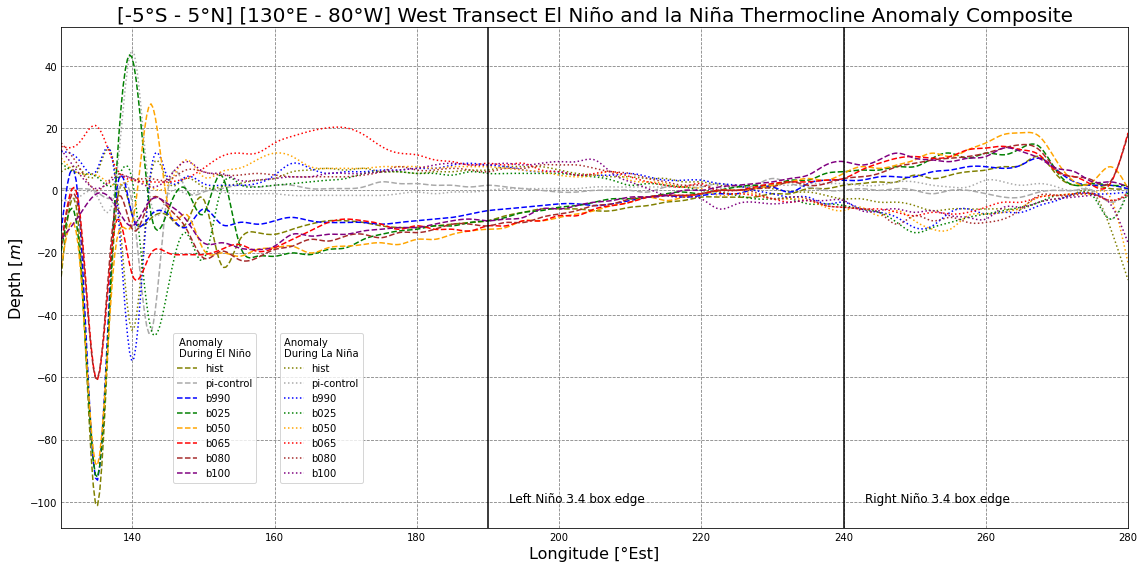

In [ ]:
################################################################################################
### [-5°S - 5°N] [130°E - 80°W] Thermocline Anlomalies during El Nino and La Nina Composite ####
######################################### last 50 years ########################################
################################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(16, 8))

for i, datasetN in enumerate(dataset_names):
   thermocline_anom_nino = ax.plot(lon_ext, cubic_spline_nino[i](lon_ext) - cubic_spline[i](lon_ext), color=colors[i], label=datasetN, linestyle='--')
   thermocline_anom_nina = ax.plot(lon_ext, cubic_spline_nina[i](lon_ext) - cubic_spline[i](lon_ext), color=colors[i], label=datasetN, linestyle=':')
 
# Legends
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::2], labels[::2], title='Anomaly \nDuring El Niño', loc='upper left', bbox_to_anchor=(0.10, 0.40))
ax.add_artist(legend)
legend_nino = ax.legend(handles[1::2], labels[1::2], title='Anomaly \nDuring La Niña', loc='upper left', bbox_to_anchor=(0.20, 0.40))

# import matplotlib.patches as mpatches
# 'fake' invisible object creation for legend
#patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]
# Set a legend
#ax.legend(patches, dataset_names, loc = 'upper right')

# Set axes options.
ax.set_title('[-5°S - 5°N] [130°E - 80°W] West Transect El Niño and la Niña Thermocline Anomaly Composite', fontsize=20)
ax.set_xlabel('Longitude [°Est]', fontsize=16)
ax.set_ylabel('Depth 'r'$[m]$', fontsize=16)
ax.set_xlim(130, 280)
#ax.set_ylim(ax.get_ylim()[::-1])
#ax.set_xticklabels(ticks, y=-0.02)
ax.grid(linestyle='--', color='gray')
ax.axvline(190, color='black', linestyle='-')
ax.text(193, -100, 'Left Niño 3.4 box edge', color='black', fontsize=12)
ax.axvline(240, color='black', linestyle='-')
ax.text(243, -100, 'Right Niño 3.4 box edge', color='black', fontsize=12)

plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_8 + 'Thermocline_CompositeNinoAnomaly.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_8 + 'Thermocline_CompositeNinaAnomaly.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

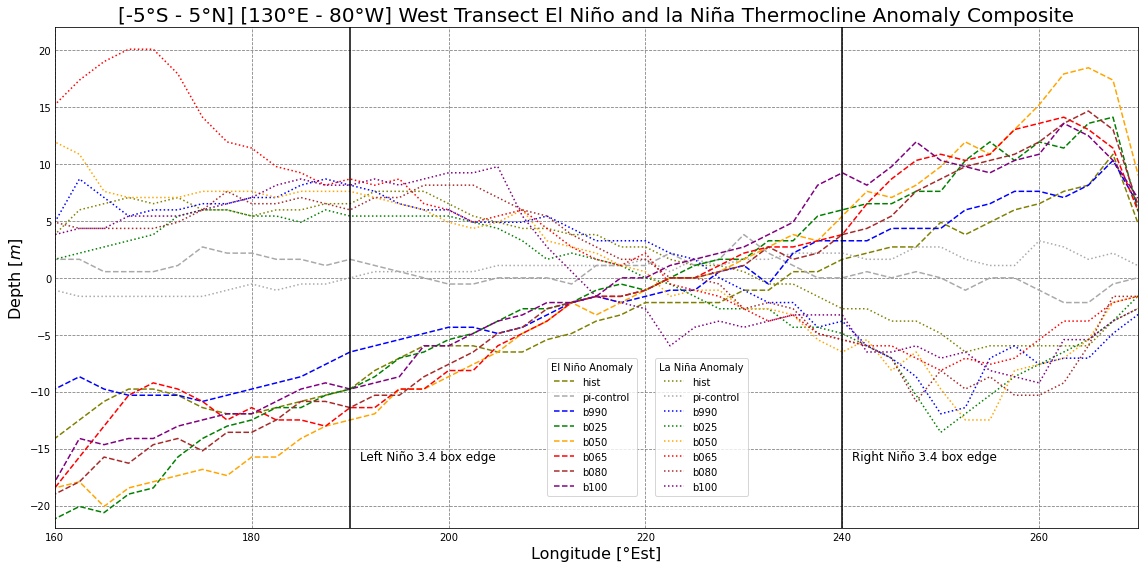

In [ ]:
################################################################################################
### [-5°S - 5°N] [160°E - 80°W] Thermocline Anlomalies during El Nino and La Nina Composite ####
######################################### last 50 years ########################################
################################################################################################

"""
Nota Bene:
Come tutti gli altri plot con l'anomalia di Nino e Nina, e non, qua le anomalie pure sono plottate dopo aver eseguito l'interpolazione spline del capo per aumentare i livelli verticali e ricalcolare il punto di massimo gradiente,
tuttavia a differnza degli altri non viene eseguita l'interpolazione (longitudinale) dei punti di massimo gradiente (lev_max_grad), la linea plottata quindi è più squadrata ma non presenta oscillazioni spurie dovute all'operazione di interpolazione-Spline.
""" 

plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(16, 8))

for i, datasetN in enumerate(dataset_names):
   thermocline_anom_nino = ax.plot(lon, lev_max_grad_nino[i] - lev_max_grad[i], color=colors[i], label=datasetN, linestyle='--') #lon_ext, cubic_spline_nino[i](lon_ext) - cubic_spline[i](lon_ext)
   thermocline_anom_nina = ax.plot(lon, lev_max_grad_nina[i] - lev_max_grad[i], color=colors[i], label=datasetN, linestyle=':') #lon_ext, cubic_spline_nina[i](lon_ext) - cubic_spline[i](lon_ext)
 
# Legends
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::2], labels[::2], title='El Niño Anomaly', loc='upper left', bbox_to_anchor=(0.45, 0.35))
ax.add_artist(legend)
legend_nino = ax.legend(handles[1::2], labels[1::2], title='La Niña Anomaly', loc='upper left', bbox_to_anchor=(0.55, 0.35))

# import matplotlib.patches as mpatches
# 'fake' invisible object creation for legend
#patches = [mpatches.Patch(color=colors[i]) for i in range(len(dataset_names))]
# Set a legend
#ax.legend(patches, dataset_names, loc = 'upper right')

# Set axes options.
ax.set_title('[-5°S - 5°N] [130°E - 80°W] West Transect El Niño and la Niña Thermocline Anomaly Composite', fontsize=20)
ax.set_xlabel('Longitude [°Est]', fontsize=16)
ax.set_ylabel('Depth 'r'$[m]$', fontsize=16)
ax.set_xlim(160, 270)
ax.set_ylim(-22, 22)
#ax.set_xticklabels(ticks, y=-0.02)
ax.grid(linestyle='--', color='gray')
ax.axvline(190, color='black', linestyle='-')
ax.text(191, -16, 'Left Niño 3.4 box edge', color='black', fontsize=12)
ax.axvline(240, color='black', linestyle='-')
ax.text(241, -16, 'Right Niño 3.4 box edge', color='black', fontsize=12)

plt.tight_layout()
# Save the current figure to a file
fig.savefig(common_Dir_home + dir_images_8 + 'Thermocline_CompositeNinoAnomalyZoom.pdf', bbox_inches='tight')
fig.savefig(common_Dir_home + dir_images_8 + 'Thermocline_CompositeNinaAnomalyZoom.jpg', bbox_inches='tight', dpi=150)
# Display the figure
plt.show()
# Chiusura immagine
plt.close()

Commento:
le oscillazioni nel west boundary a mio parere sono spurie, 130°E sono prorpio a ridosso delle filippine, mentre 140 è sopra l'isola di papua, se consideriamo il range dai 150 in poi forse è meglio. allo stesso modo ridurrei il range di oscillazione verticale a -20 - 20 per risaltare meglio le oscillazioni.
Ad ogni modo:  
- il pi-control conferma quanto visto nei grafici .contourf() del transetto: una varaiibilità tra le due fasi ENSO pressochè nulla. NB! i segni delle anomalie sembrano pure invertiti
Si nota e viene confermato il comportamento descritto nei grafici transetto:
 - per El Nino:
   - La termoclina nella warm pool si approfondisce: b990, hist, b025, b050~=b065 poi si inverte con il b080 e b100.
   - La termoclina nella Cold tongue ha un comportamento leggermente diverso: si alza progressivamente: hist, b990, poi b025,b050,b065 sono più o meno tutti lì e b080 e b100 non invertono la rotta in modo apprezzabile: che la cold tongue subisca una modifica poù unidirezionale/lineare che la warm pool durante El Nino?
 - Per La Nina:
   - La termoclina nella warm pool non subisce grosse variaizioni in tutti i tun ad eccezione del b065 che ha una davvero grossa oscillazione rispetto tutte le altre. --> quindi un comportamento meno lineare che la fase El Nino
   - Nella cold tongue, anche qui non si apprezza significativamente un trend, tutti i run sono lì. In generale, rispetto lo storico tutti mostrano un approfondimento della termoclina nella zona più occidentale di Nino1.2. A ridosso delle coste tornano ad omologarsi.